In [1]:
# Define functions for generating plots

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

def initialize_plotting_engine():
    """Initialize the plotting environment with required settings"""
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")
    # Significantly increase font size
    plt.rcParams.update({'font.size': 56})

def determine_contrast(mask_value):
    """Determine contrast based on mask value"""
    if mask_value in ["VSconstrained", "VMPFC"]:
        return "Rew>Pun"
    elif mask_value == "rFFA":
        return "Str>Com"
    elif mask_value in ["bilateralMotor", "bilateralCerebellum"]:
        return "Avg (L>R, R>L)"
    else:
        return "Unknown"  # Default case

def extract_file_data(base_dir, type_value, img_value, mask_value, denoise_value):
    """Extract data from files matching the given parameters"""
    # Updated pattern to handle complex type values with underscores
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-((?:act|ppi_seed-VS_thr5))_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    # Dictionary to store data by subject
    data_by_subject = {}
    
    # List of all expected acquisition parameters
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    
    # Find all text files in the directory
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            
            # Skip subjects with 'sp' in their ID
            if 'sp' in sub_id:
                continue
                
            # Check if this file matches our target parameters
            if (file_type == type_value and img == img_value 
                and mask == mask_value and denoise == denoise_value):
                
                # Read the value from the file
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                        
                    # Initialize subject data if not already present
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in acq_params}
                    
                    # Store the value
                    data_by_subject[sub_id][acq] = value
                    
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    return data_by_subject

def create_dataframe(data_by_subject, headcoil_64_subjects):
    """Create a DataFrame from the collected data"""
    # List of all expected acquisition parameters
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    
    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    
    # Reset index to make subject ID a column and rename it
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    # Add headcoil column
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in headcoil_64_subjects else 20)
    
    # Reorder columns to ensure correct order (subject, headcoil, then acquisition parameters)
    column_order = ['subject', 'headcoil'] + acq_params
    df = df[column_order]
    
    # Sort by subject ID (as integers)
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    
    return df

def prepare_plot_data(df):
    """Prepare data for plotting by calculating means and errors by headcoil type"""
    # List of all expected acquisition parameters
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    
    # Split by headcoil type
    df_20 = df[df['headcoil'] == 20]
    df_64 = df[df['headcoil'] == 64]
    
    results = {}
    
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        # Calculate means and standard errors for each acquisition
        means = {}
        errors = {}
        
        for acq in acq_params:
            means[acq] = hc_df[acq].mean()
            errors[acq] = hc_df[acq].sem()  # Standard error of the mean
        
        results[hc_name] = {
            'means': means,
            'errors': errors,
            'count': len(hc_df)
        }
    
    return results

def create_bar_plots(plot_data, mask_value, contrast, is_first=False, is_last=False):
    """Create bar plots for the given data"""
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Define the x positions for the bars - make them closer together
    width = 0.4  # Width for bars
    
    # Reduce spacing between bars - make x positions closer together
    x1 = [0, 1.2, 2.4]  # Positions for me1 bars (closer together)
    x2 = [0+width, 1.2+width, 2.4+width]  # Positions for me4 bars
    
    # Colors
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    
    # Separate the means and errors for easier plotting
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        
        # Create two sets of bars (me1 and me4)
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        
        # Plot the bars
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        
        # Only show y-label for the left plot (Headcoil 20) - SIMPLIFIED to just show mask
        if i == 0:  # Left plot (Headcoil 20)
            ax.set_ylabel(f"{mask_value}", fontsize=56)  # Simplified Y-axis label
        
        # Only include titles in the first figure
        if is_first:
            ax.set_title(f"{title}", fontsize=64, fontweight='bold')
            if i == 0:  # Left plot (Headcoil 20)
                ax.set_title(f"{title}\nn={count}", fontsize=56, fontweight='bold')
            else:  # Right plot (Headcoil 64)
                ax.set_title(f"{title}\nn={count}", fontsize=56, fontweight='bold')
        
        # Set x-axis ticks and labels - with closer spacing
        ax.set_xticks([width/2, 1.2+width/2, 2.4+width/2])  # Center ticks between each pair of bars
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=56)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=56)
        
        # Add legend only to the first right plot (Headcoil 64 of first mask) - LARGER LEGEND
        if is_first and i == 1:  # This is the first right plot
            # Create a much larger legend
            legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=112)  # Doubled font size from 56 to 112
            legend.get_title().set_fontsize(112)  # Also double the title font size
            # Position legend in upper right corner
            ax.legend(loc='upper right')
        
        # Set y-limit to start slightly below the minimum value
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        
        y_min = min([v-e for v, e in zip(y_values, y_errors)])
        y_max = max([v+e for v, e in zip(y_values, y_errors)])
        
        margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - margin, y_max + margin)
    
    # For the last plot, add a centered x-axis label below both subplots - MOVED LOWER
    if is_last:
        # Move the label further down to avoid overlapping with x-tick labels
        fig.text(0.5, -0.05, 'Multiband Factor', ha='center', fontsize=56)
    
    # Reduce padding between subplots
    plt.tight_layout(pad=1.0)
    
    # For the last plot, adjust the bottom margin to make room for the x-axis label
    if is_last:
        plt.subplots_adjust(bottom=0.2)  # Add extra space at the bottom
        
    return fig

def process_mask(base_dir, type_value, img_value, mask_value, denoise_value, headcoil_64_subjects, 
                 is_first=False, is_last=False, save_files=True):
    """Process a single mask and create the corresponding plots and data"""
    contrast = determine_contrast(mask_value)
    
    print(f"\nProcessing files with parameters: type={type_value}, img={img_value}, mask={mask_value}, denoise={denoise_value}")
    print(f"Using contrast: {contrast}")
    
    # Extract data from files
    data_by_subject = extract_file_data(base_dir, type_value, img_value, mask_value, denoise_value)
    
    if not data_by_subject:
        print(f"No matching files found for mask: {mask_value}")
        return None
    
    # Create DataFrame
    df = create_dataframe(data_by_subject, headcoil_64_subjects)
    
    if save_files:
        # Save to CSV with contrast in filename
        output_file = f"multiecho_data_{type_value}_{img_value}_{mask_value}_{denoise_value}_{contrast.replace('>', 'gt').replace(' ', '_').replace(',', '')}.csv"
        df.to_csv(output_file, index=False)
        print(f"Data saved to {output_file}")
    
    print(f"Found data for {len(df)} subjects")
    
    # Display the first few rows
    print("\nSample of the data:")
    print(df.head())
    
    # Count headcoil types
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get(64, 0)}")
    print(f"20-channel: {headcoil_counts.get(20, 0)}")
    
    # Prepare data for plotting
    plot_data = prepare_plot_data(df)
    
    # Create and save bar plots
    print("\nCreating bar plots...")
    fig = create_bar_plots(plot_data, mask_value, contrast, is_first, is_last)
    
    if save_files:
        # Save the plot with contrast in filename
        plot_file = f"multiecho_plots_{type_value}_{img_value}_{mask_value}_{denoise_value}_{contrast.replace('>', 'gt').replace(' ', '_').replace(',', '')}.png"
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved as '{plot_file}'")
    
    return {
        'dataframe': df,
        'figure': fig,
        'contrast': contrast,
        'plot_data': plot_data
    }

def run_analysis(type_value, img_value, mask_values, denoise_value, base_dir=None, save_files=True):
    """Run the full analysis for the given parameters"""
    # Define default base directory if not provided
    if base_dir is None:
        base_dir = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
    
    # Subjects with headcoil value of 64 (all others will be 20)
    headcoil_64_subjects = [
        "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
        "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
        "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
        "10186", "10188", "10221"
    ]
    
    # Initialize plotting environment
    initialize_plotting_engine()
    
    # Print the TYPE_VALUE and IMG_VALUE at the start
    print(f"\nAnalysis Parameters: TYPE_VALUE={type_value.upper()}, IMG_VALUE={img_value.capitalize()}")
    
    results = {}
    
    # Process each mask value
    for i, mask_value in enumerate(mask_values):
        # Determine if this is the first mask or the last mask
        is_first = (i == 0)
        is_last = (i == len(mask_values) - 1)
        
        # Process the mask
        result = process_mask(
            base_dir=base_dir,
            type_value=type_value,
            img_value=img_value, 
            mask_value=mask_value,
            denoise_value=denoise_value,
            headcoil_64_subjects=headcoil_64_subjects,
            is_first=is_first,
            is_last=is_last,
            save_files=save_files
        )
        
        if result:
            results[mask_value] = result
    
    return results




Analysis Parameters: TYPE_VALUE=ACT, IMG_VALUE=Tsnr

Processing files with parameters: type=act, img=tsnr, mask=VSconstrained, denoise=base
Using contrast: Rew>Pun
Data saved to multiecho_data_act_tsnr_VSconstrained_base_RewgtPun.csv
Found data for 40 subjects

Sample of the data:
    subject  headcoil      mb1me1      mb3me1      mb6me1      mb1me4  \
15    10017        64   93.171561   96.472227   72.965402  144.371994   
16    10024        64   77.064609   99.994980   96.563391  129.308568   
7     10035        64   93.250309   82.999944   66.527981  156.552988   
22    10041        64   87.334805   71.660396   72.598291   95.940405   
0     10043        64  114.347315  102.607047  104.771022  129.872137   

        mb3me4      mb6me4  
15  129.632584   96.623616  
16  125.774294   99.689409  
7   127.698453  101.742537  
22  100.651173   89.853786  
0   112.657809   91.791882  

Headcoil counts:
64-channel: 23
20-channel: 17

Creating bar plots...
Plot saved as 'multiecho_plots_ac

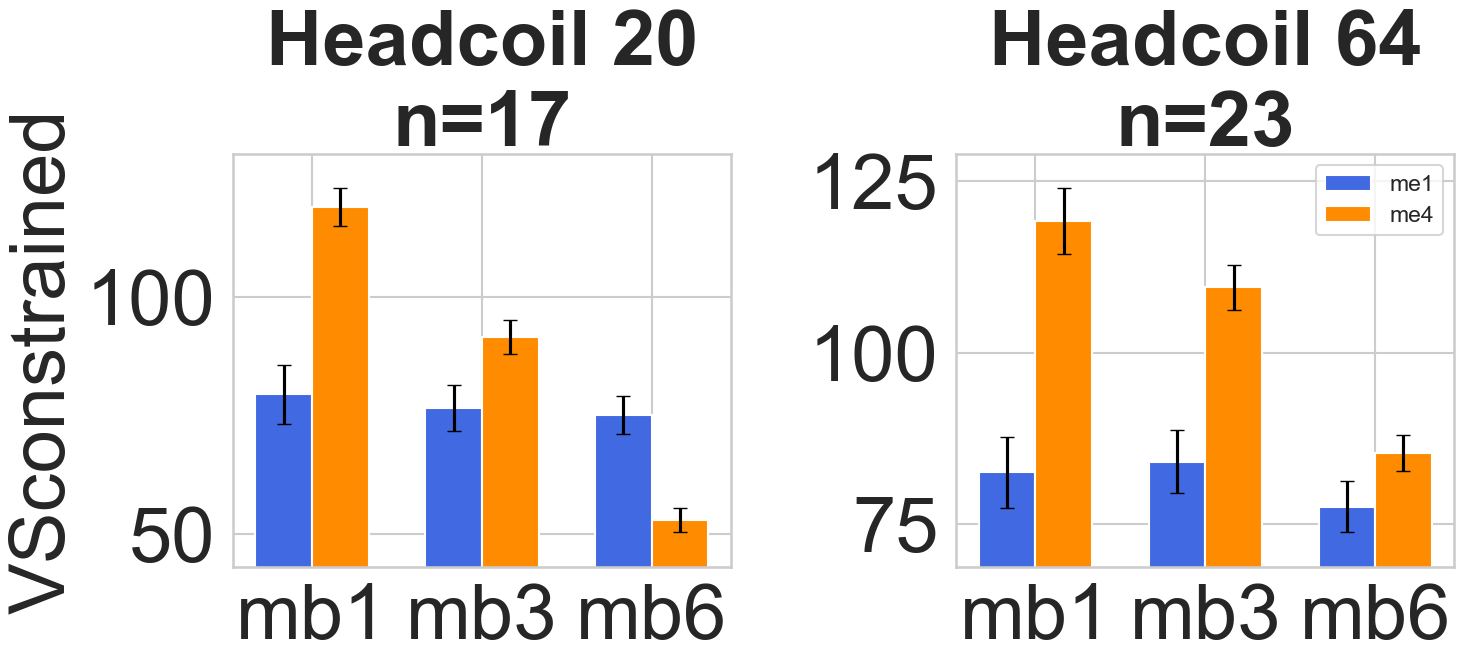

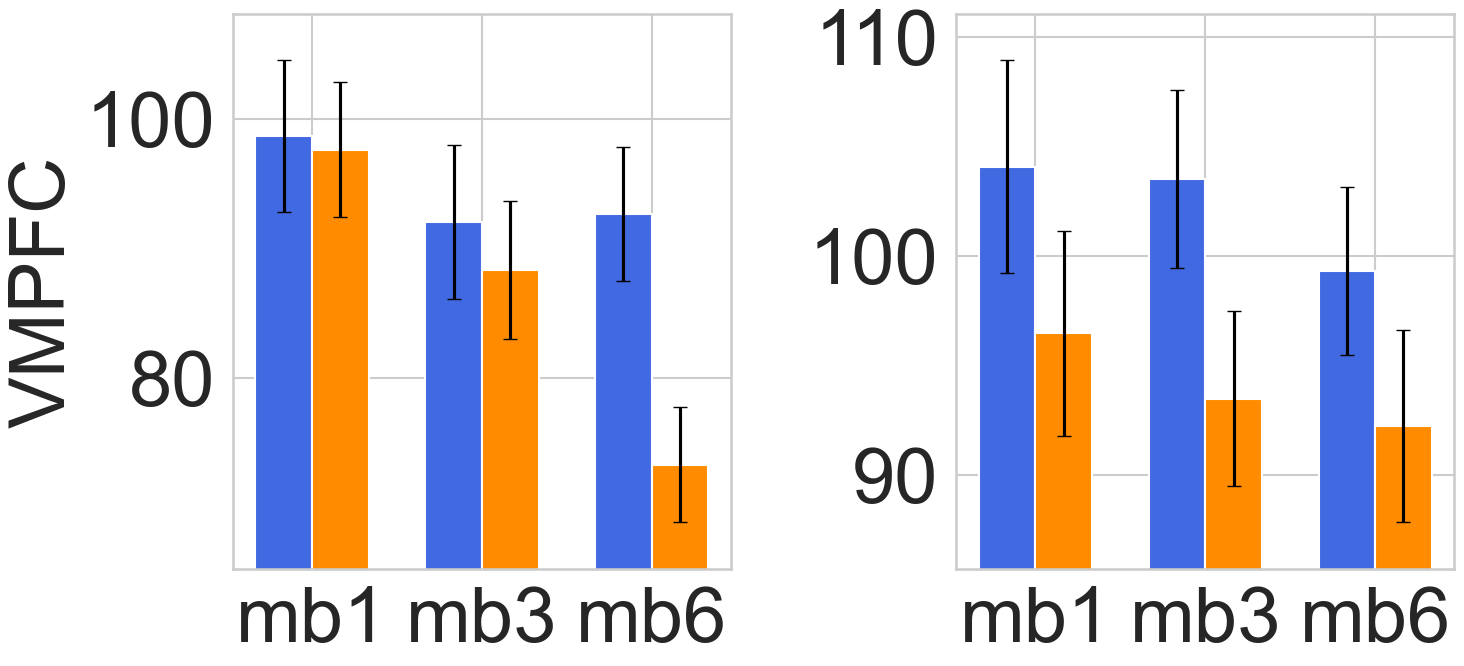

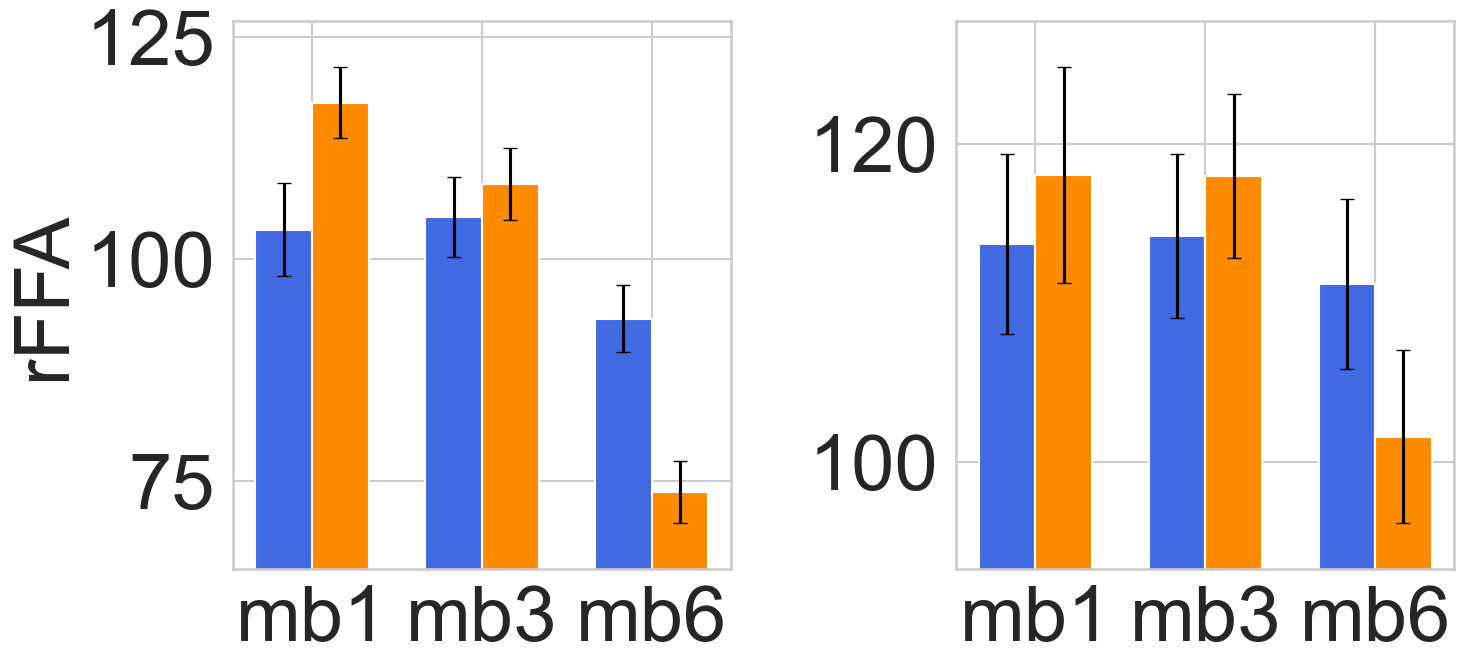

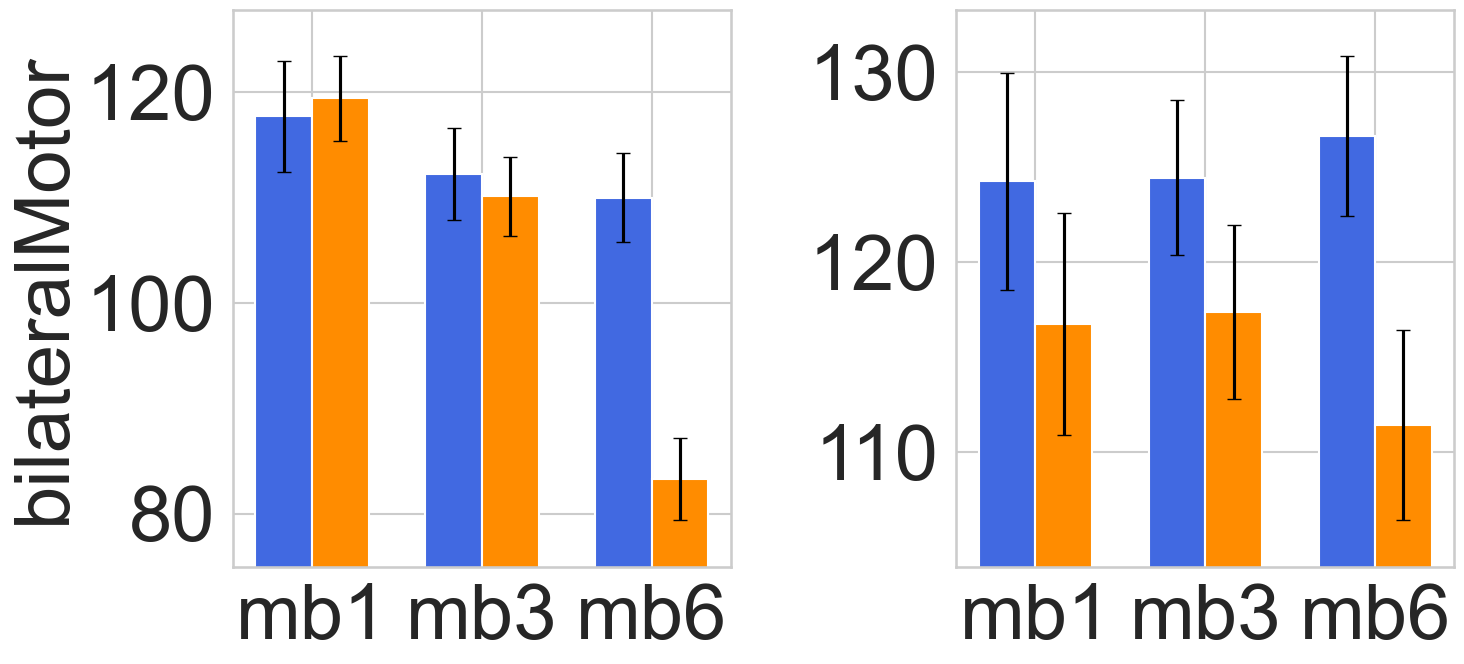

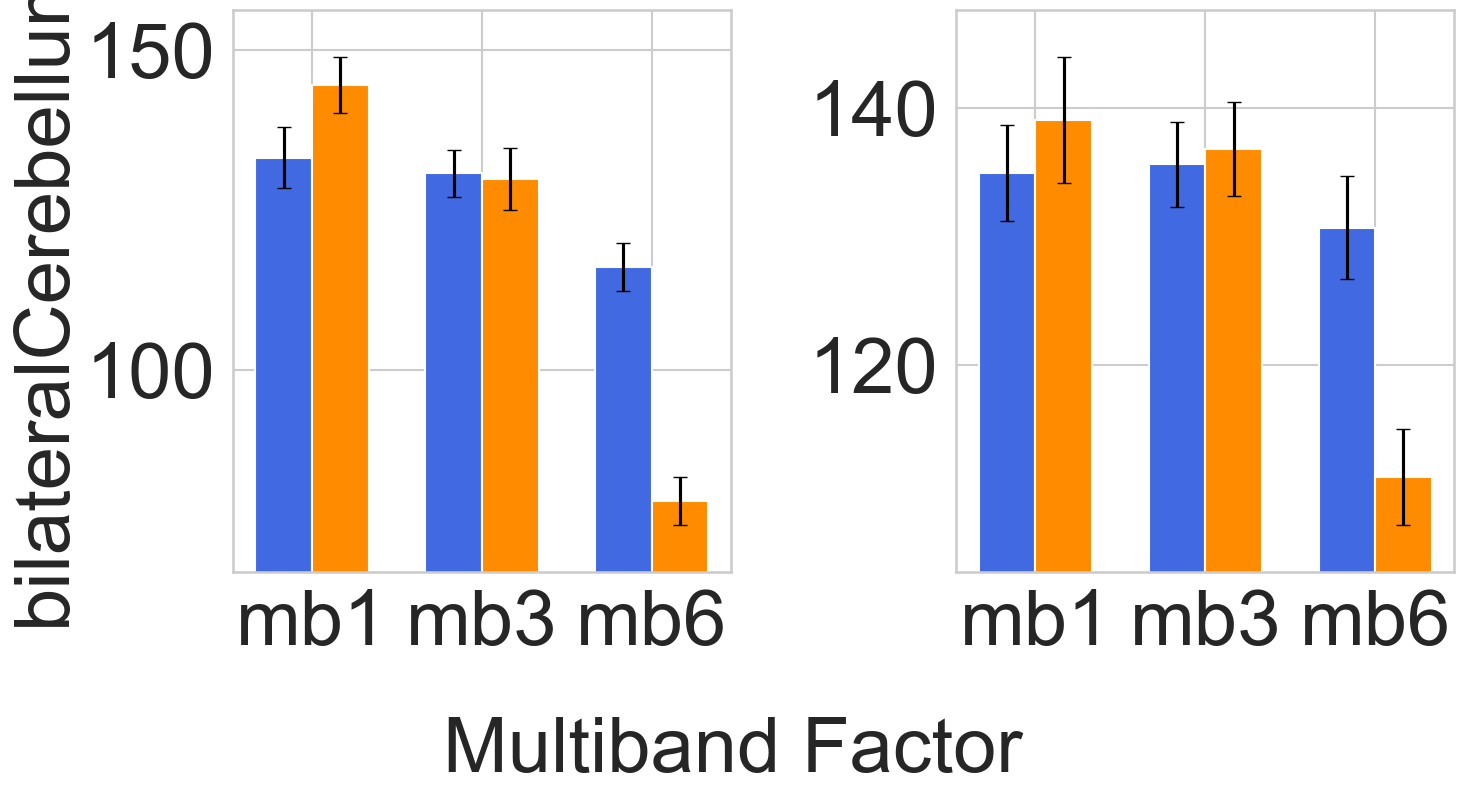

In [3]:
# Figure 5. TSNR by acquisition in each ROI
TYPE_VALUE = "act" # "act" "ppi_seed-VS_thr5"
IMG_VALUE = "tsnr" # "tsnr" "beta" "zstat"
MASK_VALUES = ["VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"] # "VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"
DENOISE_VALUE = "base" # "base" "tedana"

# Run the analysis with the new parameters
results = run_analysis(TYPE_VALUE, IMG_VALUE, MASK_VALUES, DENOISE_VALUE)


Analysis Parameters: TYPE_VALUE=ACT, IMG_VALUE=Beta

Processing files with parameters: type=act, img=beta, mask=VSconstrained, denoise=base
Using contrast: Rew>Pun
Data saved to multiecho_data_act_beta_VSconstrained_base_RewgtPun.csv
Found data for 40 subjects

Sample of the data:
    subject  headcoil      mb1me1      mb3me1      mb6me1      mb1me4  \
15    10017        64   -4.671750   94.225272 -104.142611 -162.286756   
14    10024        64  108.144702  171.678553  -71.579402  194.614259   
6     10035        64  177.945209   31.420981  -54.147004  346.247572   
38    10041        64  -49.422607  139.081973   60.893990  199.377341   
35    10043        64   40.083598  171.309089  261.922597  522.679206   

        mb3me4      mb6me4  
15   99.403756  -85.024436  
14  373.619278  223.327079  
6  -154.840010   11.494569  
38   85.674422  407.643753  
35  311.496890  234.641249  

Headcoil counts:
64-channel: 23
20-channel: 17

Creating bar plots...
Plot saved as 'multiecho_plots_ac

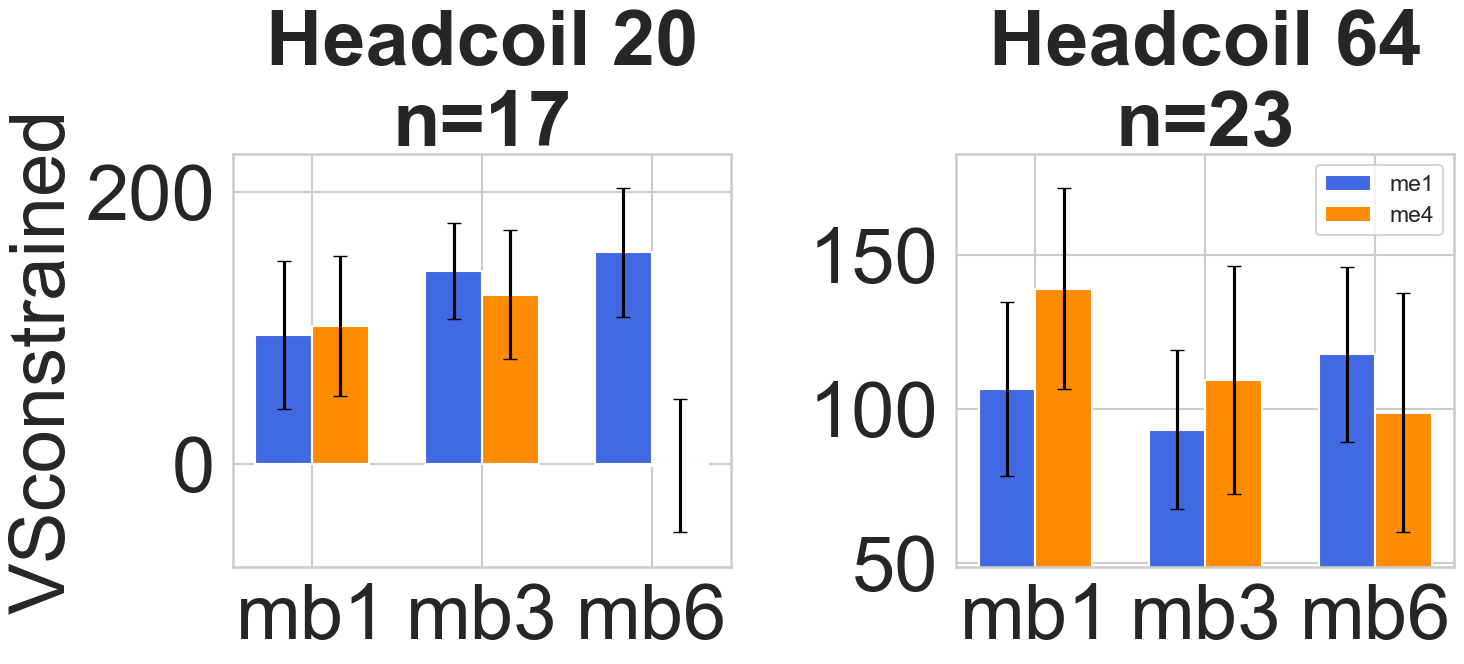

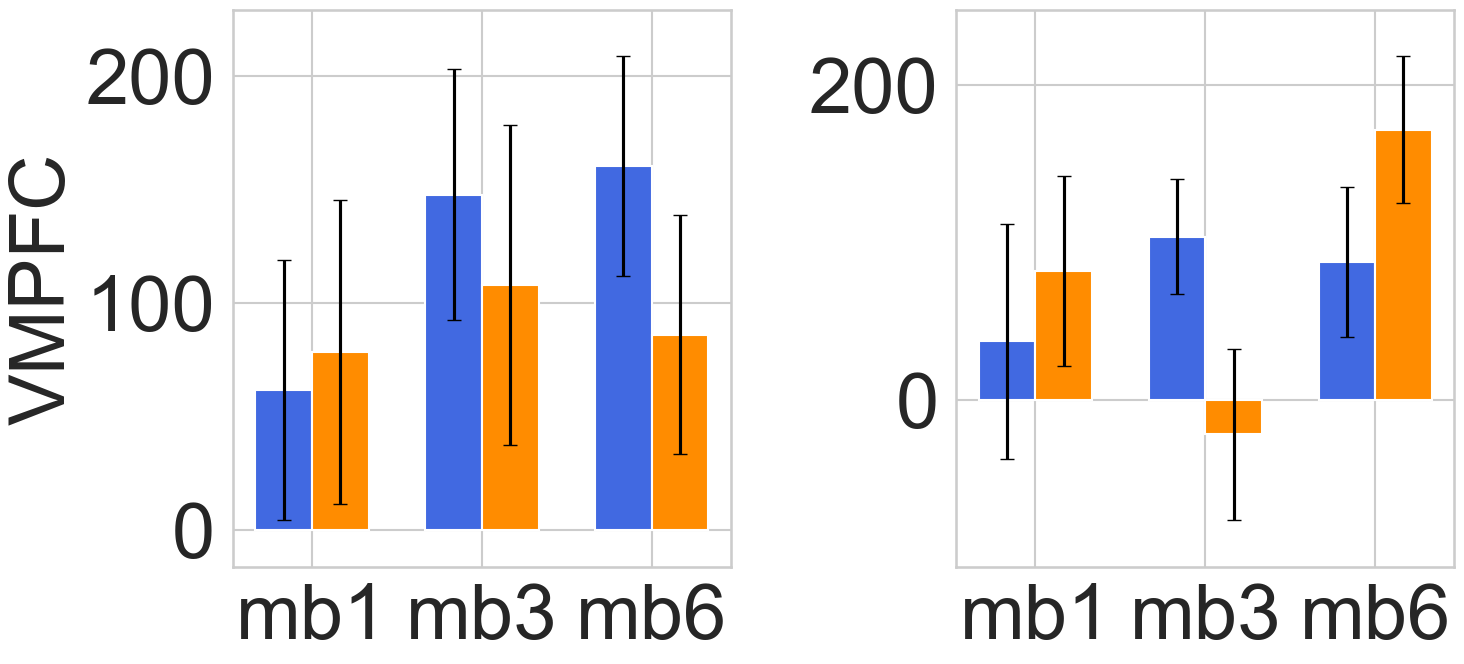

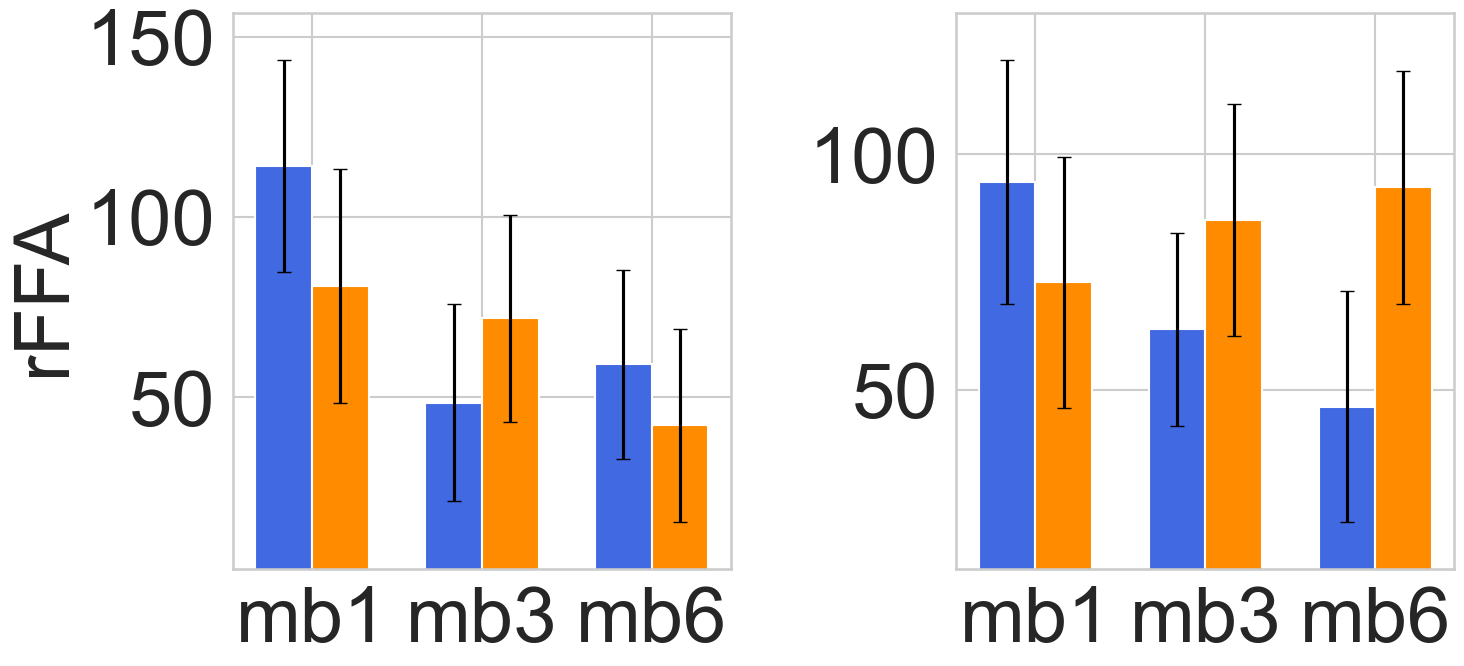

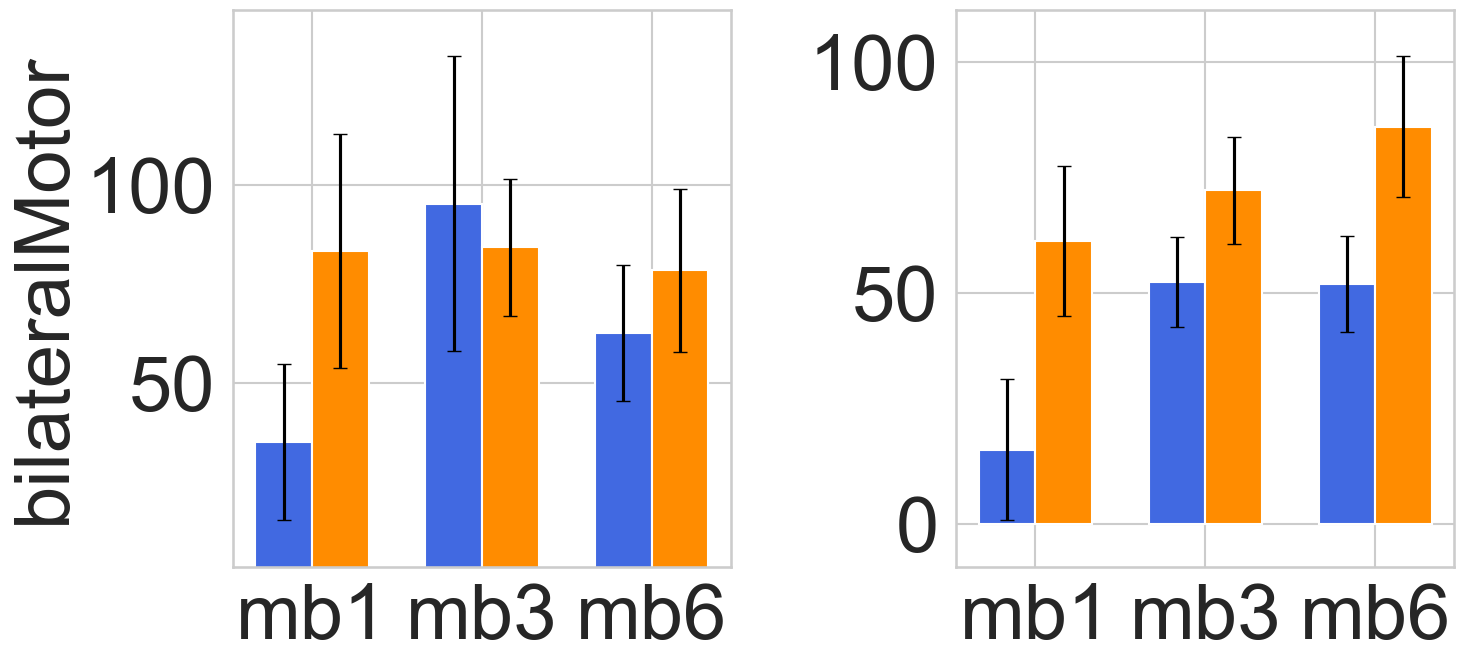

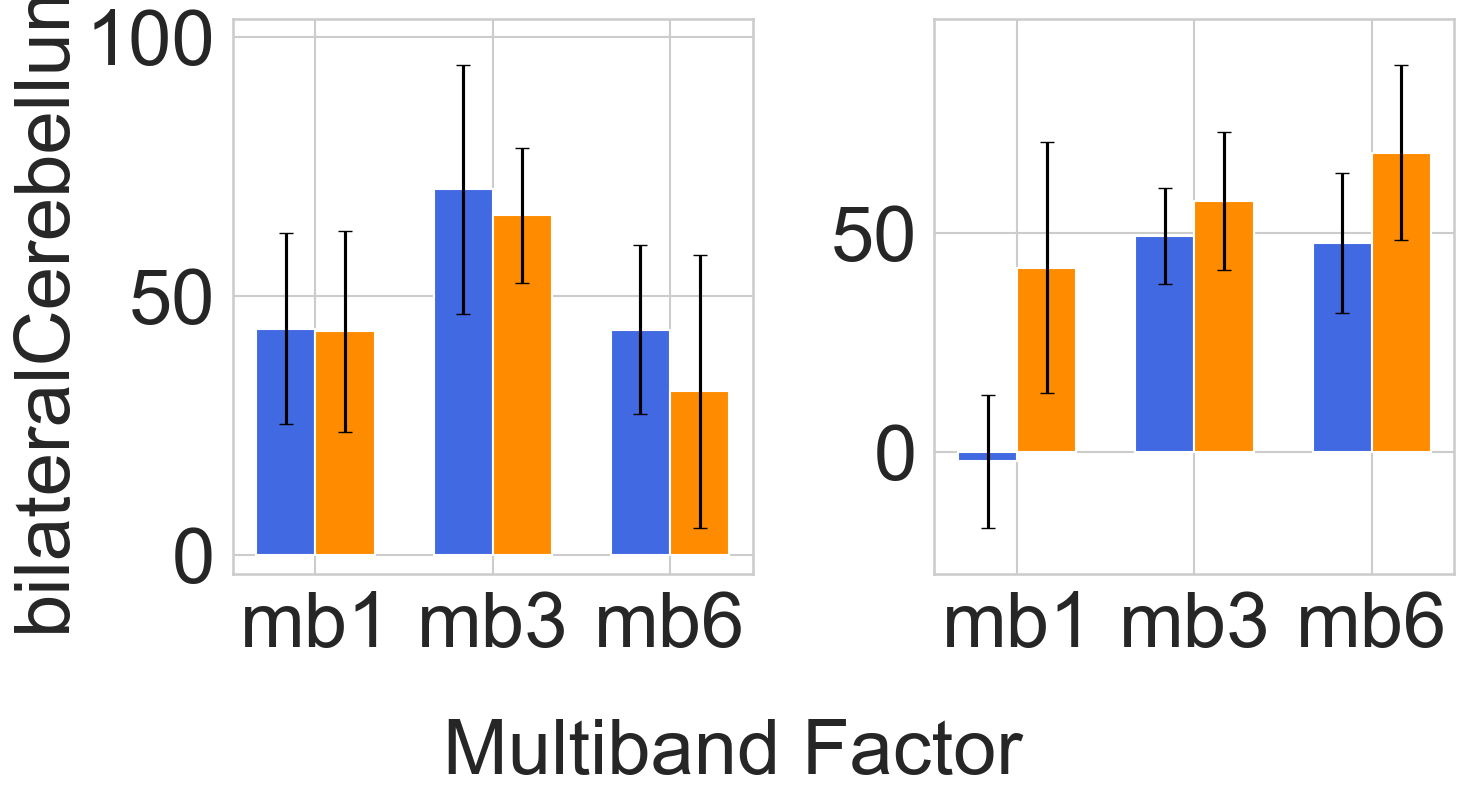

In [5]:
# Figure 6. Beta estimates for activation for each acquisition in each ROI
TYPE_VALUE = "act" # "act" "ppi_seed-VS_thr5"
IMG_VALUE = "beta" # "tsnr" "beta" "zstat"
MASK_VALUES = ["VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"] # "VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"
DENOISE_VALUE = "base" # "base" "tedana"

# Run the analysis with the new parameters
results = run_analysis(TYPE_VALUE, IMG_VALUE, MASK_VALUES, DENOISE_VALUE)


Analysis Parameters: TYPE_VALUE=ACT, IMG_VALUE=Zstat

Processing files with parameters: type=act, img=zstat, mask=VSconstrained, denoise=base
Using contrast: Rew>Pun
Data saved to multiecho_data_act_zstat_VSconstrained_base_RewgtPun.csv
Found data for 40 subjects

Sample of the data:
    subject  headcoil    mb1me1    mb3me1    mb6me1    mb1me4    mb3me4  \
25    10017        64 -0.052341  0.092611 -0.226344 -0.109317  0.125530   
32    10024        64  0.222361  0.609214 -0.343321  0.342741  1.116233   
7     10035        64  0.413395  0.157308 -0.332888  0.638243 -0.496693   
23    10041        64 -0.214285  0.464856  0.229929  0.332726  0.233385   
37    10043        64  0.063261  0.582494  1.209953  0.798848  0.840201   

      mb6me4  
25 -0.068198  
32  0.733408  
7   0.036513  
23  1.281765  
37  0.677401  

Headcoil counts:
64-channel: 23
20-channel: 17

Creating bar plots...
Plot saved as 'multiecho_plots_act_zstat_VSconstrained_base_RewgtPun.png'

Processing files with param

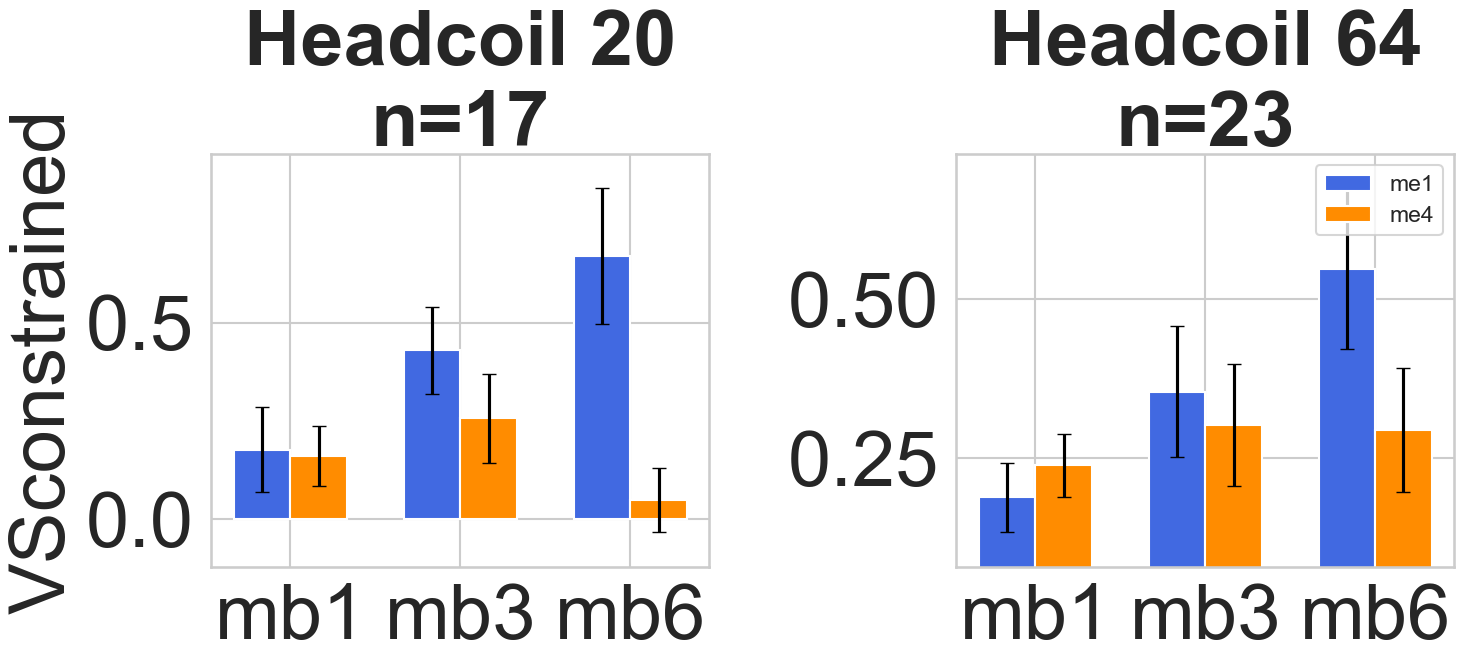

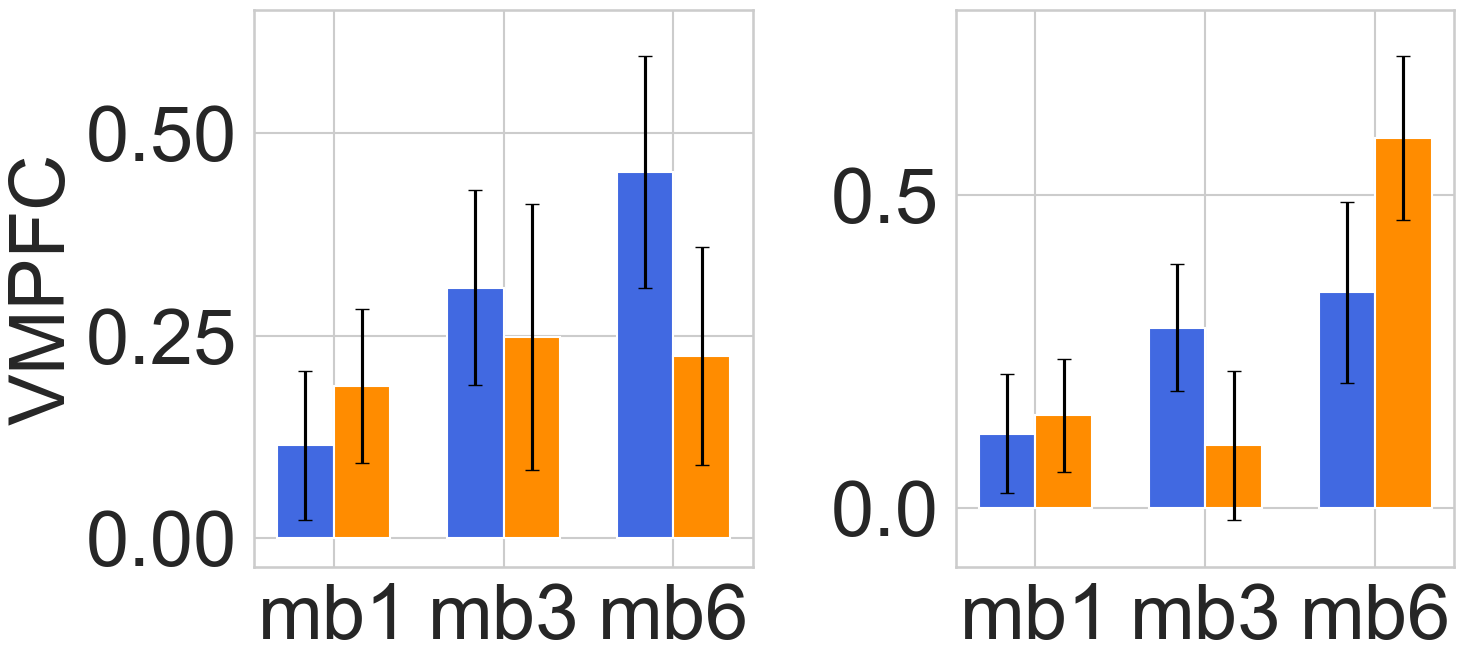

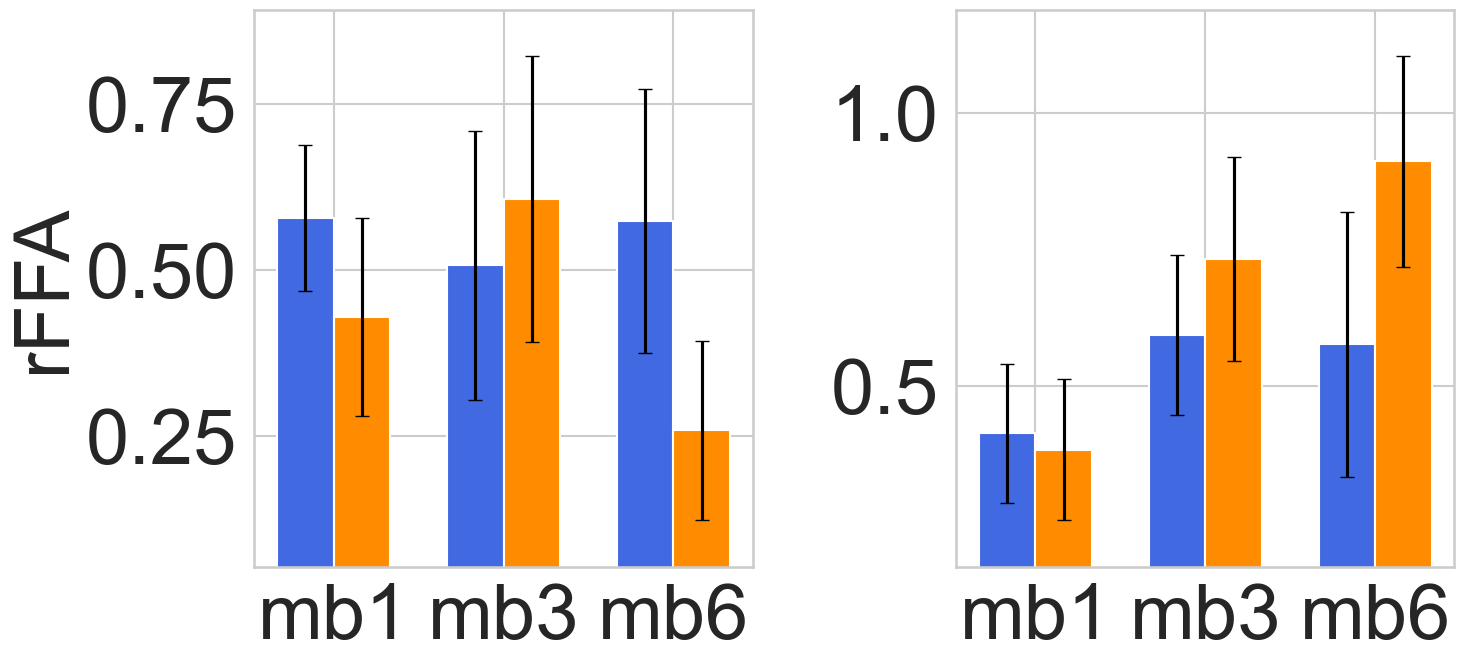

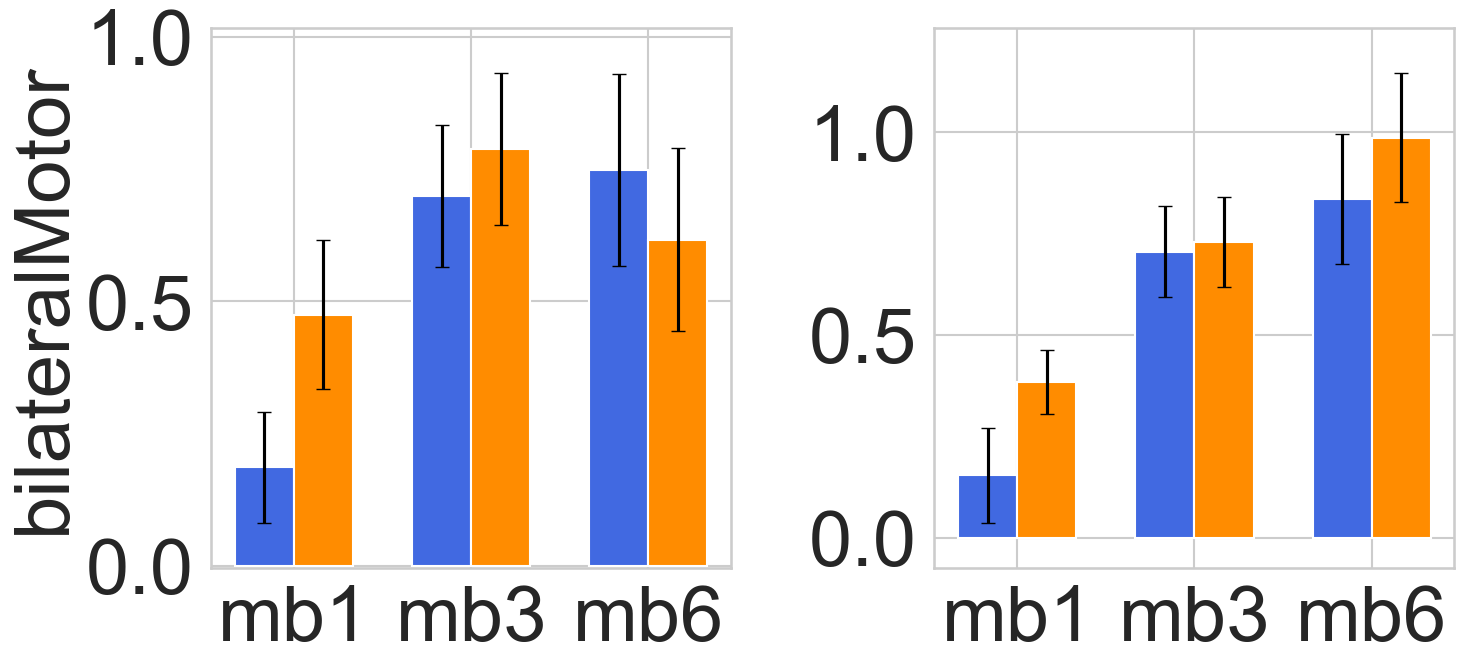

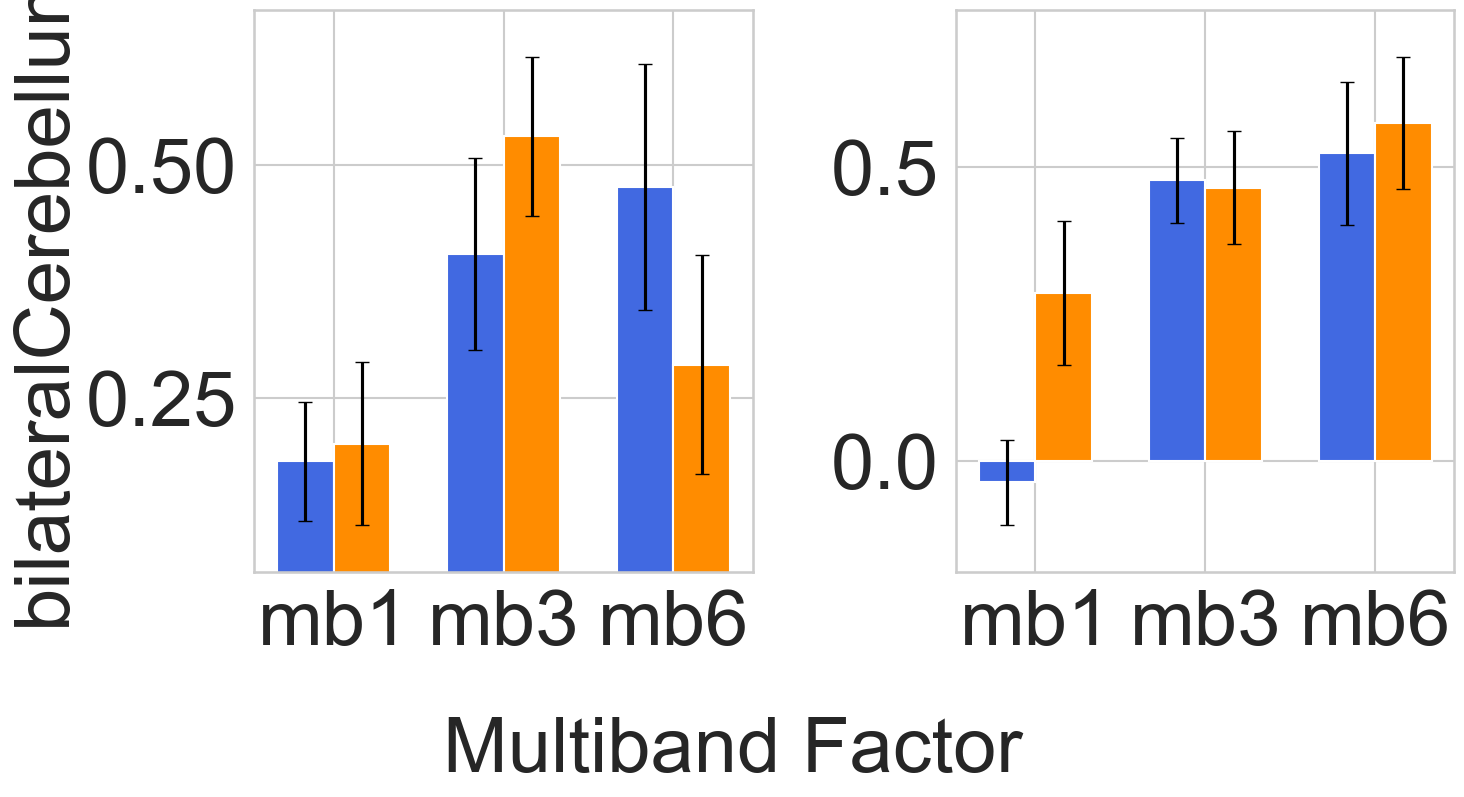

In [7]:
# Supp. Figure 6. zstats for activation for each acquisition in each ROI
TYPE_VALUE = "act" # "act" "ppi_seed-VS_thr5"
IMG_VALUE = "zstat" # "tsnr" "beta" "zstat"
MASK_VALUES = ["VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"] # "VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"
DENOISE_VALUE = "base" # "base" "tedana"

# Run the analysis with the new parameters
results = run_analysis(TYPE_VALUE, IMG_VALUE, MASK_VALUES, DENOISE_VALUE)


Analysis Parameters: TYPE_VALUE=PPI_SEED-VS_THR5, IMG_VALUE=Beta

Processing files with parameters: type=ppi_seed-VS_thr5, img=beta, mask=VMPFC, denoise=base
Using contrast: Rew>Pun
Data saved to multiecho_data_ppi_seed-VS_thr5_beta_VMPFC_base_RewgtPun.csv
Found data for 40 subjects

Sample of the data:
    subject  headcoil     mb1me1    mb3me1    mb6me1     mb1me4     mb3me4  \
25    10017        64  89.297388  3.913389  3.338511  57.453720  18.124263   
2     10024        64  -4.599379  0.440359 -0.649661   8.634791   2.706911   
4     10035        64   0.774104 -5.131424 -2.803471  -3.788675  -1.941951   
28    10041        64  -8.152401  2.219746  0.854800  -1.913513   4.673571   
31    10043        64  -2.994230  0.318628  1.226043   7.946105  -0.549515   

      mb6me4  
25  5.610220  
2  -0.759237  
4   0.132748  
28 -1.609837  
31 -0.567247  

Headcoil counts:
64-channel: 23
20-channel: 17

Creating bar plots...
Plot saved as 'multiecho_plots_ppi_seed-VS_thr5_beta_VMPFC_base_

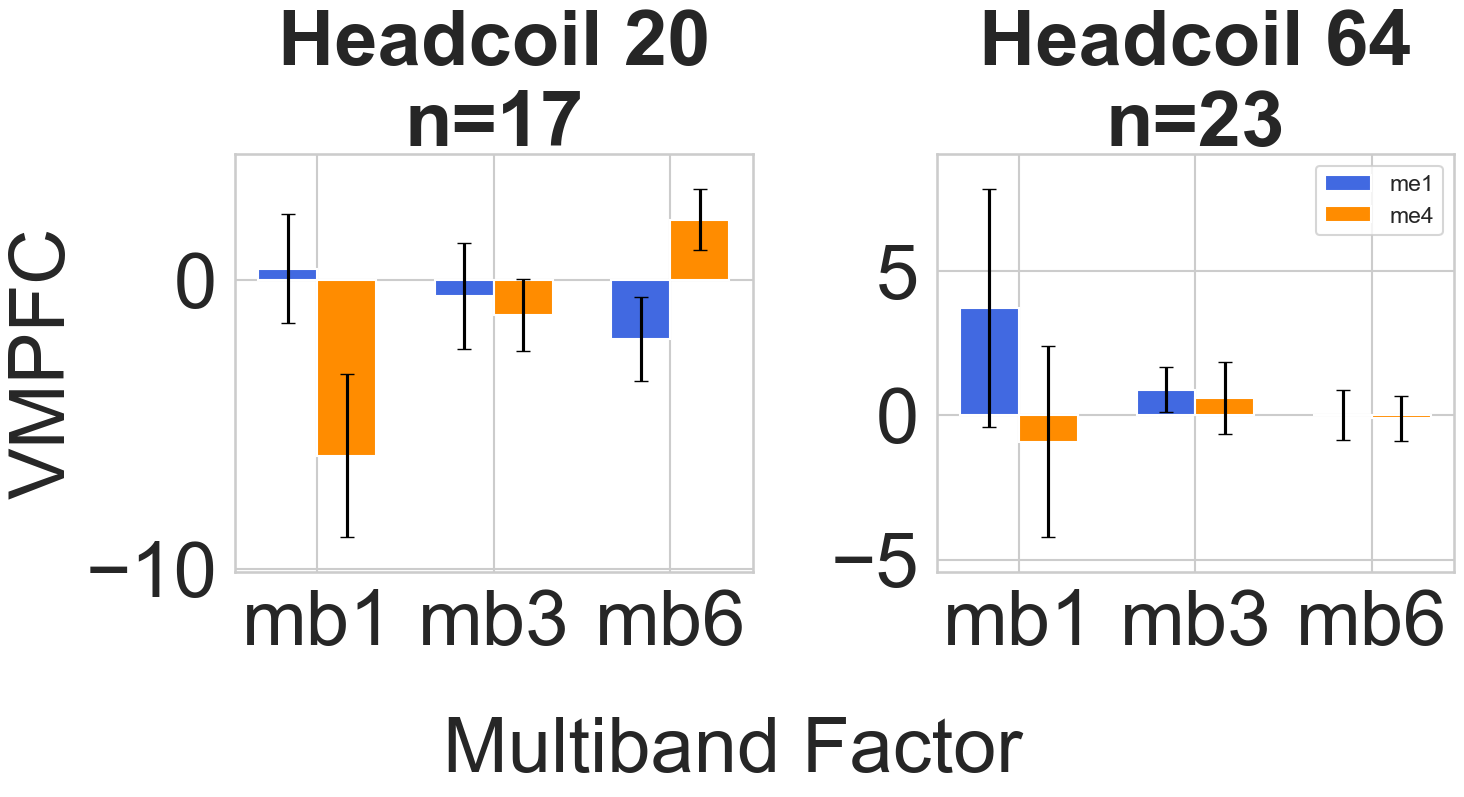

In [9]:
# Figure 7. Beta estimates for ppi for each acquisition in VMPFC
TYPE_VALUE = "ppi_seed-VS_thr5" # "act" "ppi_seed-VS_thr5"
IMG_VALUE = "beta" # "tsnr" "beta" "zstat"
MASK_VALUES = ["VMPFC"] # "VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"
DENOISE_VALUE = "base" # "base" "tedana"

# Run the analysis with the new parameters
results = run_analysis(TYPE_VALUE, IMG_VALUE, MASK_VALUES, DENOISE_VALUE)


Analysis Parameters: TYPE_VALUE=PPI_SEED-VS_THR5, IMG_VALUE=Zstat

Processing files with parameters: type=ppi_seed-VS_thr5, img=zstat, mask=VMPFC, denoise=base
Using contrast: Rew>Pun
Data saved to multiecho_data_ppi_seed-VS_thr5_zstat_VMPFC_base_RewgtPun.csv
Found data for 40 subjects

Sample of the data:
    subject  headcoil    mb1me1    mb3me1    mb6me1    mb1me4    mb3me4  \
17    10017        64  0.406330  0.138988  0.154490  0.129046  0.102802   
5     10024        64 -0.335370  0.036821 -0.105762  0.297115  0.305760   
19    10035        64  0.080598 -0.741936 -0.644463 -0.180664 -0.282070   
24    10041        64 -0.458875  0.396962  0.142223 -0.160802  0.325056   
34    10043        64 -0.172289  0.049024  0.278389  0.186595 -0.036370   

      mb6me4  
17  0.257606  
5  -0.045831  
19  0.059568  
24 -0.182981  
34 -0.049467  

Headcoil counts:
64-channel: 23
20-channel: 17

Creating bar plots...
Plot saved as 'multiecho_plots_ppi_seed-VS_thr5_zstat_VMPFC_base_RewgtPun.png'


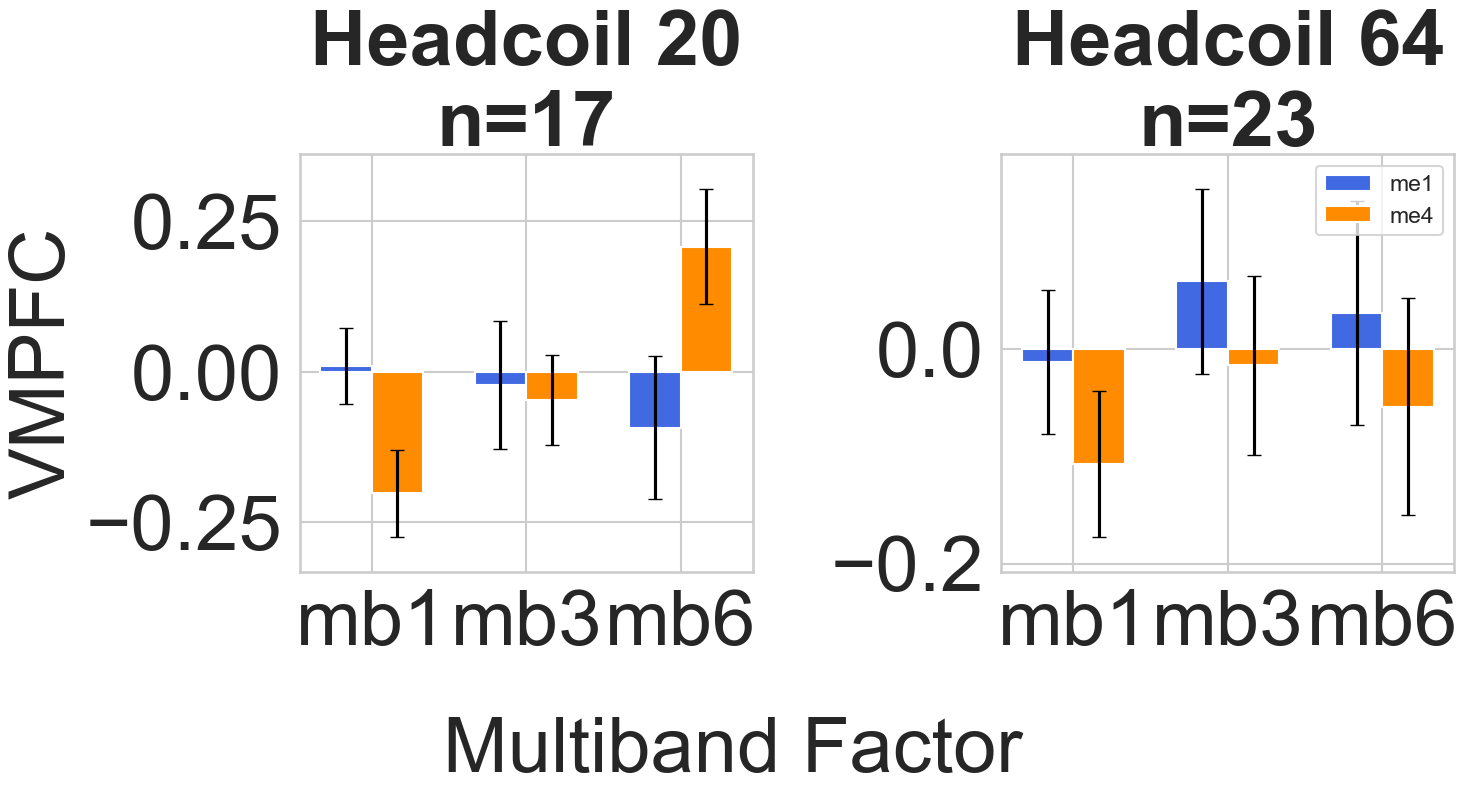

In [11]:
# Supp. Figure 7. zstats for ppi for each acquisition in VMPFC
TYPE_VALUE = "ppi_seed-VS_thr5" # "act" "ppi_seed-VS_thr5"
IMG_VALUE = "zstat" # "tsnr" "beta" "zstat"
MASK_VALUES = ["VMPFC"] # "VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"
DENOISE_VALUE = "base" # "base" "tedana"

# Run the analysis with the new parameters
results = run_analysis(TYPE_VALUE, IMG_VALUE, MASK_VALUES, DENOISE_VALUE)

In [13]:
# Figure 8 Part 1, Generate avg fd_mean values for each ME acq
import pandas as pd

# Define file paths
input_file = "~/Documents/GitHub/multiecho-pilot/derivatives/Task-sharedreward_Level-Acq_Outlier-info_mriqc-0.16.1.tsv"
output_file = "~/Documents/GitHub/multiecho-pilot/code/fd_mean_values.csv"

# Load the TSV file
df = pd.read_csv(input_file, sep="\t")

# Filter out subjects ending in 'sp' and acquisitions containing 'me1'
df = df[~df['Sub'].str.endswith('sp')]
df = df[~df['acq'].str.contains('me1', na=False)]

# Save the filtered DataFrame to a CSV file
df.to_csv(output_file, index=False)

#print("Filtered data saved to:", output_file)

import pandas as pd

# Load your spreadsheet data
df = pd.read_csv(output_file)

# Extract the base 'acq' substring (e.g., mb1me4, mb3me4, mb6me4) from the 'acq' column
df['acq_base'] = df['acq'].str.extract(r'(mb\dme4)')

# Group by 'Sub' and 'acq_base' and calculate the average of 'fd_mean' for each group
averages = df.groupby(['Sub', 'acq_base'])['fd_mean'].mean().reset_index()

# Save the results to a new spreadsheet
output_file_path = 'fd_mean_averages.xlsx'  # Replace with your desired output file path
averages.to_excel(output_file_path, index=False)

# Optionally, print the averages to verify
print(averages)


          Sub acq_base   fd_mean
0   sub-10017   mb1me4  0.065809
1   sub-10017   mb3me4  0.093968
2   sub-10017   mb6me4  0.087372
3   sub-10028   mb1me4  0.043817
4   sub-10028   mb3me4  0.082697
..        ...      ...       ...
86  sub-10716   mb3me4  0.579043
87  sub-10738   mb1me4  0.326083
88  sub-12042   mb1me4  0.091052
89  sub-12042   mb3me4  0.103584
90  sub-12042   mb6me4  0.100240

[91 rows x 3 columns]


In [15]:
# Figure 8 part 2, define function for Figure 8 plots

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

def initialize_plotting_engine():
    """Initialize the plotting environment with required settings"""
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")
    # Significantly increase font size
    plt.rcParams.update({'font.size': 56})

def extract_file_data_with_difference(base_dir, type_value, img_value, mask_value, denoise_tedana, denoise_base, acq_params):
    """Extract data and calculate differences between denoise methods for given parameters"""
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-(.+?)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    data_by_subject = {}
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    print(f"Found {len(file_paths)} files in {base_dir}")
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id or acq not in acq_params:
                continue
            if (file_type == type_value and img == img_value and mask == mask_value and 
                denoise in [denoise_tedana, denoise_base]):
                try:
                    with open(file_path, 'r') as f:
                        raw_content = f.read().strip()
                        value = float(raw_content)
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {
                            denoise: {acq_param: np.nan for acq_param in acq_params}
                            for denoise in [denoise_tedana, denoise_base]
                        }
                    data_by_subject[sub_id][denoise][acq] = value
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    print(f"Subjects with data: {len(data_by_subject)}")
    
    diff_by_subject = {}
    for sub_id, data in data_by_subject.items():
        diff_by_subject[sub_id] = {}
        for acq in acq_params:
            tedana_val = data[denoise_tedana].get(acq, np.nan)
            base_val = data[denoise_base].get(acq, np.nan)
            diff = tedana_val - base_val if not (np.isnan(tedana_val) or np.isnan(base_val)) else np.nan
            diff_by_subject[sub_id][acq] = diff
    
    return diff_by_subject

def create_dataframe_with_fd(diff_by_subject, fd_csv_path, acq_params, headcoil_64_subjects):
    """Create and merge DataFrame with framewise displacement data"""
    df = pd.DataFrame.from_dict(diff_by_subject, orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    df['subject'] = df['subject'].astype(str)
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in headcoil_64_subjects else 20)
    column_order = ['subject', 'headcoil'] + acq_params
    df = df[column_order]
    df.sort_values('subject', inplace=True)
    
    df_long = df.melt(id_vars=['subject', 'headcoil'], value_vars=acq_params, 
                      var_name='acq', value_name='tedana_minus_base')
    
    fd_df = pd.read_csv(fd_csv_path)
    fd_df = fd_df.rename(columns={'Sub': 'subject', 'acq_base': 'acq'})
    fd_df['subject'] = fd_df['subject'].str.replace('sub-', '', regex=False)
    fd_df['acq'] = fd_df['acq'].str.extract(r'(mb[1-6]me\d)')
    
    df_merged = pd.merge(df_long, fd_df[['subject', 'acq', 'fd_mean']], 
                         on=['subject', 'acq'], how='left')
    
    nan_count = df_merged['fd_mean'].isna().sum()
    print(f"\nNumber of NaN fd_mean values after merge: {nan_count} out of {len(df_merged)} rows")
    
    return df_merged

def create_scatter_plots(df, acq_params, mask_value, denoise_tedana, denoise_base):
    """Create two batches of scatter plots:
       1. Split by headcoil (red for 20, green for 64)
       2. No split by headcoil (blue dots)
    """
    fig, axes = plt.subplots(1, len(acq_params), figsize=(24, 8), sharey=True)

    # Colors for headcoil scatter plots
    colors = {20: 'red', 64: 'green'}
    legend_handles = []

    for i, acq in enumerate(acq_params):
        ax = axes[i]
        acq_data = df[df['acq'] == acq]

        # Scatter plot with headcoil split
        scatter = sns.scatterplot(
            data=acq_data, x='fd_mean', y='tedana_minus_base',
            hue='headcoil', palette=colors, ax=ax, s=300  # Larger dots
        )

        # Capture legend handles for later use
        if i == 0:
            legend_handles = scatter.legend_.legendHandles

        # Regression lines for each headcoil
        for hc in [20, 64]:
            hc_data = acq_data[acq_data['headcoil'] == hc]
            if len(hc_data) > 1:  # Need at least 2 points for regression
                sns.regplot(x='fd_mean', y='tedana_minus_base', data=hc_data,
                            scatter=False, ax=ax, color=colors[hc], line_kws={'linewidth': 3})

        # Set title for each subplot
        ax.set_title(f'{acq}', fontsize=64, fontweight='bold')

        # Only add y-label to the first subplot
        if i == 0:
            ax.set_ylabel(f'{mask_value}\n{denoise_tedana} - {denoise_base}', fontsize=56)
        else:
            ax.set_ylabel('')

        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=56)

        # Remove individual legends
        ax.legend().remove()

        # Remove redundant x-labels (fd_mean under each plot)
        ax.set_xlabel('')

    # Fine-tuned x-axis label position (closer to ticks)
    fig.text(0.5, -0.02, 'Mean Framewise Displacement', ha='center', fontsize=56)

    # Adjust layout to make space for the legend
    plt.subplots_adjust(right=0.8)

    # Add a single legend outside the plots (with smaller text and simple labels)
    fig.legend(legend_handles, ['20', '64'], title='Headcoil',
               loc='center left', bbox_to_anchor=(1, 0.5), fontsize=28, title_fontsize=28)

    plt.tight_layout()

    # Create second batch of plots (no headcoil split, all dots blue)
    fig2, axes2 = plt.subplots(1, len(acq_params), figsize=(24, 8), sharey=True)

    for i, acq in enumerate(acq_params):
        ax2 = axes2[i]
        acq_data = df[df['acq'] == acq]

        # Scatter plot (all blue)
        sns.scatterplot(
            data=acq_data, x='fd_mean', y='tedana_minus_base',
            color='blue', ax=ax2, s=300
        )

        # Regression line for all data points
        if len(acq_data) > 1:
            sns.regplot(x='fd_mean', y='tedana_minus_base', data=acq_data,
                        scatter=False, ax=ax2, color='blue', line_kws={'linewidth': 3})

        ax2.set_title(f'{acq}', fontsize=64, fontweight='bold')

        # Only add y-label to the first subplot
        if i == 0:
            ax2.set_ylabel(f'{mask_value}\n{denoise_tedana} - {denoise_base}', fontsize=56)
        else:
            ax2.set_ylabel('')

        ax2.tick_params(axis='both', which='major', labelsize=56)

        # Remove redundant x-labels
        ax2.set_xlabel('')

    # Fine-tuned x-axis label for second batch
    fig2.text(0.5, -0.02, 'Mean Framewise Displacement', ha='center', fontsize=56)

    plt.tight_layout()

    return fig, fig2


def process_and_visualize_tedana_difference(type_value, img_value, mask_value, denoise_tedana, denoise_base, 
                                           base_dir=None, fd_csv_path=None, acq_params=None, 
                                           headcoil_64_subjects=None, save_files=True):
    """Run the full analysis for tedana-base difference visualization"""
    # Define default values if not provided
    if base_dir is None:
        base_dir = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
    
    if fd_csv_path is None:
        fd_csv_path = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/code/fd_mean_values.csv")
    
    if acq_params is None:
        acq_params = ["mb1me4", "mb3me4", "mb6me4"]
    
    if headcoil_64_subjects is None:
        headcoil_64_subjects = [
            "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
            "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
            "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
            "10186", "10188", "10221"
        ]
    
    # Initialize plotting environment
    initialize_plotting_engine()
    
    print(f"\nProcessing files for tedana - base difference: type={type_value}, img={img_value}, mask={mask_value}")
    
    # Extract data and calculate differences
    diff_by_subject = extract_file_data_with_difference(
        base_dir, type_value, img_value, mask_value, denoise_tedana, denoise_base, acq_params
    )
    
    if not diff_by_subject:
        print("No matching files found.")
        return None
    
    # Create and merge DataFrame with FD data
    df = create_dataframe_with_fd(diff_by_subject, fd_csv_path, acq_params, headcoil_64_subjects)
    
    if save_files:
        # Save to CSV
        output_file = f"multiecho_tedana_minus_base_{type_value}_{img_value}_{mask_value}.csv"
        df.to_csv(output_file, index=False)
        print(f"Data saved to {output_file}")
    
    print(f"Found data for {len(df['subject'].unique())} subjects")
    
    # Display the first few rows
    print("\nSample of the merged data:")
    print(df.head())
    
    # Create scatter plots
    print("\nCreating scatter plots...")
    fig = create_scatter_plots(df, acq_params, mask_value, denoise_tedana, denoise_base)
    
    if save_files:
        # Save the plot
        plot_file = f"tedana_minus_base_scatter_{type_value}_{img_value}_{mask_value}.png"
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved as '{plot_file}'")
    
    return {
        'dataframe': df,
        'figure': fig
    }



Processing files for tedana - base difference: type=act, img=beta, mask=VSconstrained
Found 7795 files in /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/derivatives/extractions
Subjects with data: 40

Number of NaN fd_mean values after merge: 45 out of 345 rows
Data saved to multiecho_tedana_minus_base_act_beta_VSconstrained.csv
Found data for 40 subjects

Sample of the merged data:
  subject  headcoil     acq  tedana_minus_base   fd_mean
0   10017        64  mb1me4         -53.038474  0.065809
1   10017        64  mb1me4         -53.038474  0.065809
2   10017        64  mb1me4         -53.038474  0.065809
3   10017        64  mb1me4         -53.038474  0.065809
4   10024        64  mb1me4          41.439633       NaN

Creating scatter plots...


/var/folders/m6/p7f91dqd37d_mdjnjbx6xdy80000gn/T/ipykernel_2471/162252632.py:114: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend_handles = scatter.legend_.legendHandles


Plot saved as 'tedana_minus_base_scatter_act_beta_VSconstrained.png'


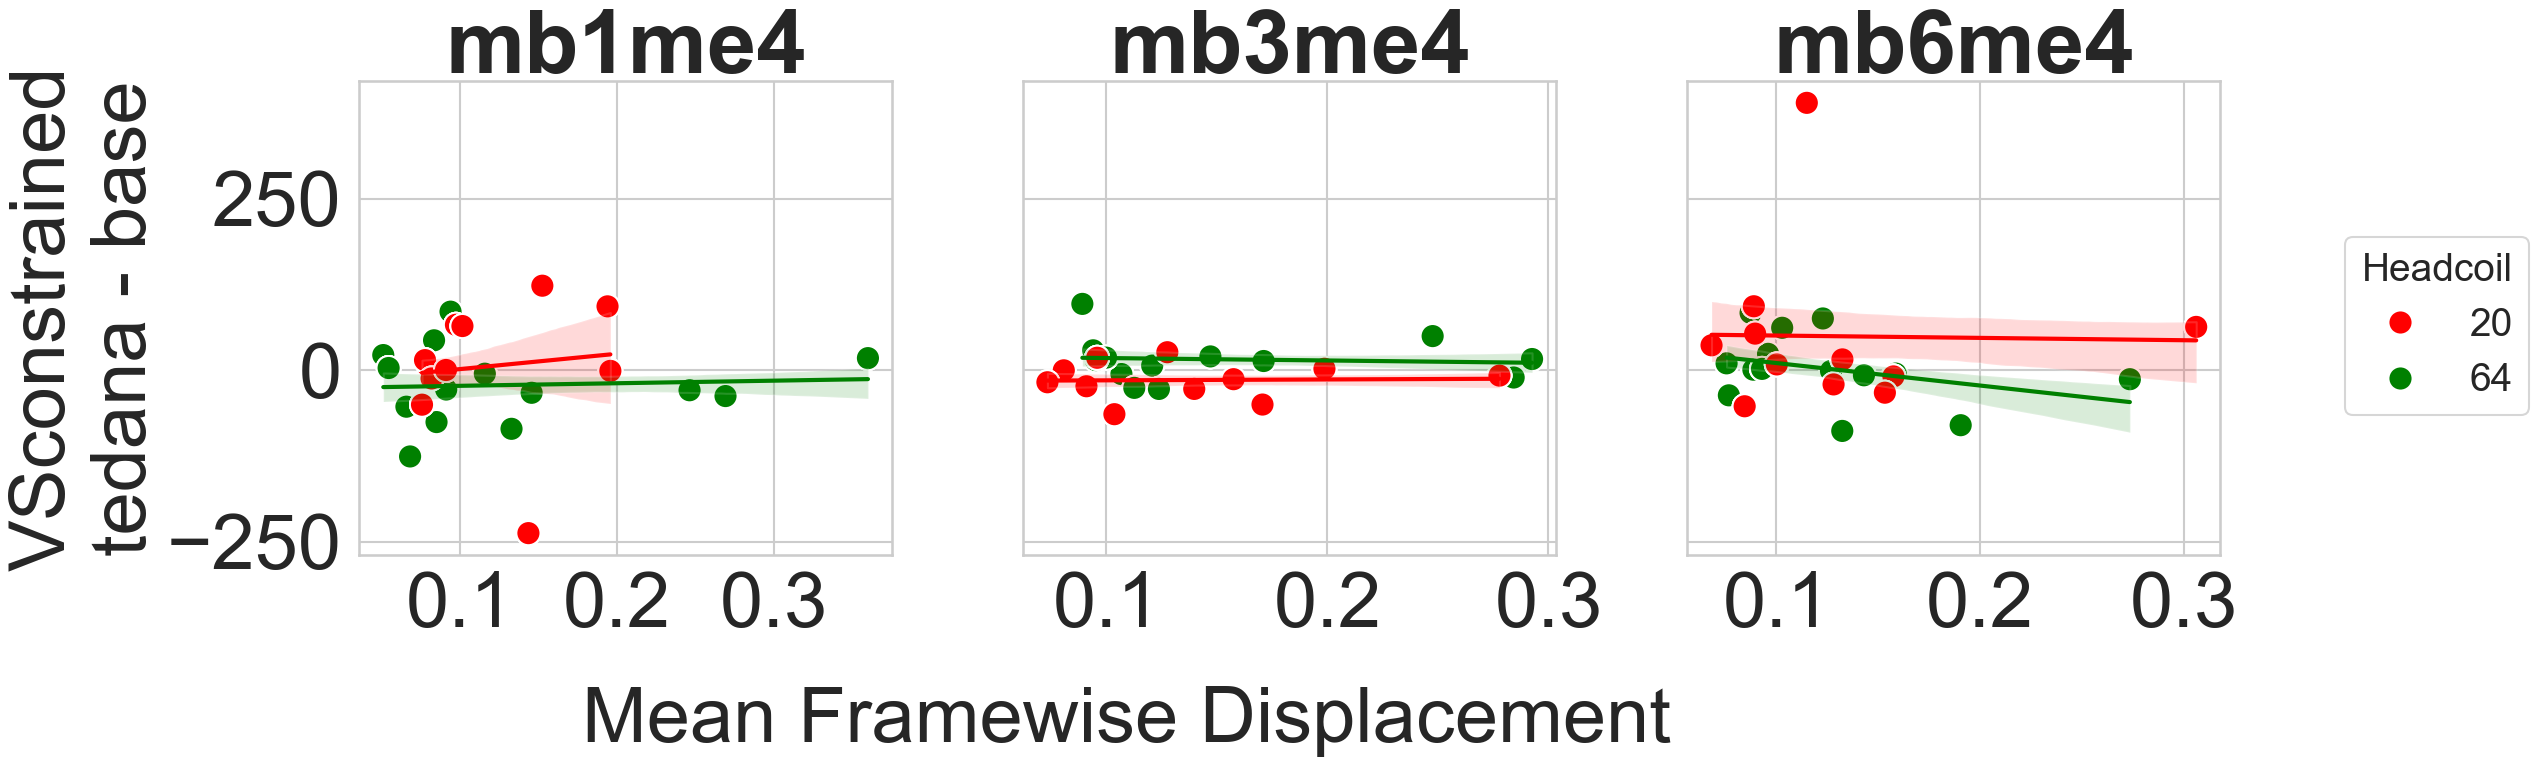

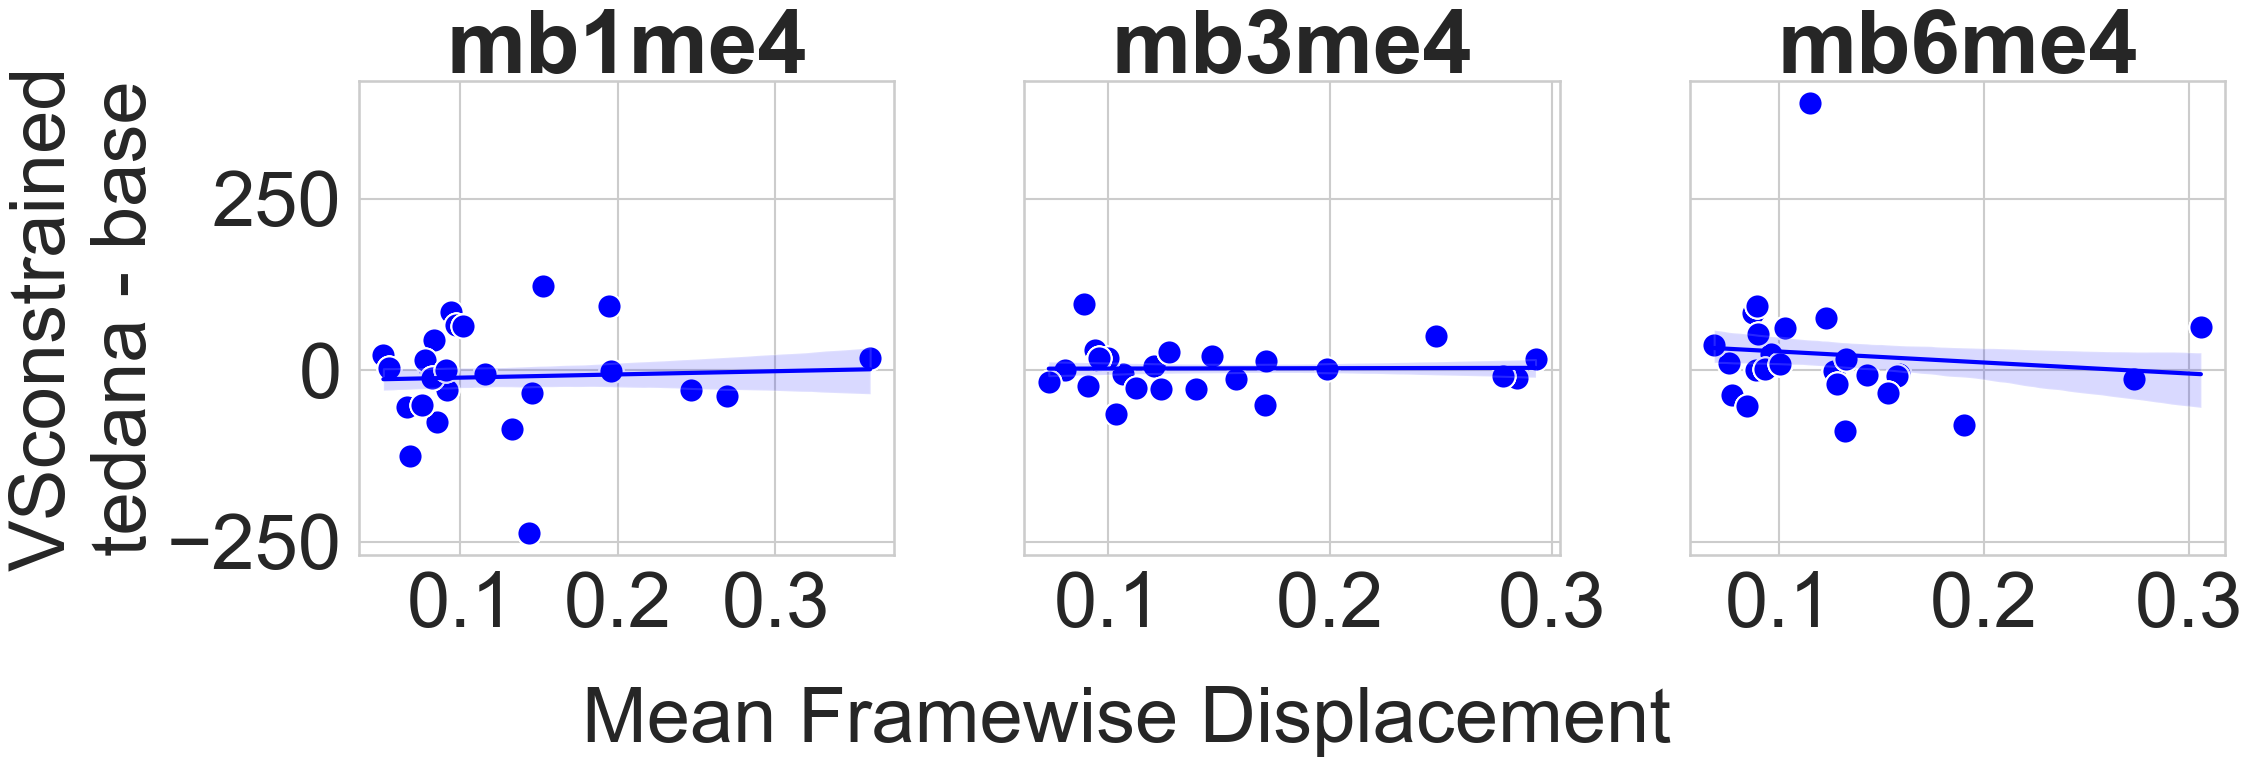

In [17]:
# Figure 8. VSconstrained
if __name__ == "__main__":
    # Parameters that can be changed to repurpose the script
    TYPE_VALUE = "act"
    IMG_VALUE = "beta"
    MASK_VALUE = "VSconstrained"
    DENOISE_TEDANA = "tedana"
    DENOISE_BASE = "base"
    
    # Run the analysis
    result = process_and_visualize_tedana_difference(
        TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_TEDANA, DENOISE_BASE
    )


Processing files for tedana - base difference: type=act, img=beta, mask=VMPFC
Found 7795 files in /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/derivatives/extractions
Subjects with data: 40

Number of NaN fd_mean values after merge: 45 out of 345 rows
Data saved to multiecho_tedana_minus_base_act_beta_VMPFC.csv
Found data for 40 subjects

Sample of the merged data:
  subject  headcoil     acq  tedana_minus_base   fd_mean
0   10017        64  mb1me4         -54.501605  0.065809
1   10017        64  mb1me4         -54.501605  0.065809
2   10017        64  mb1me4         -54.501605  0.065809
3   10017        64  mb1me4         -54.501605  0.065809
4   10024        64  mb1me4          14.709958       NaN

Creating scatter plots...


/var/folders/m6/p7f91dqd37d_mdjnjbx6xdy80000gn/T/ipykernel_2471/162252632.py:114: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend_handles = scatter.legend_.legendHandles


Plot saved as 'tedana_minus_base_scatter_act_beta_VMPFC.png'


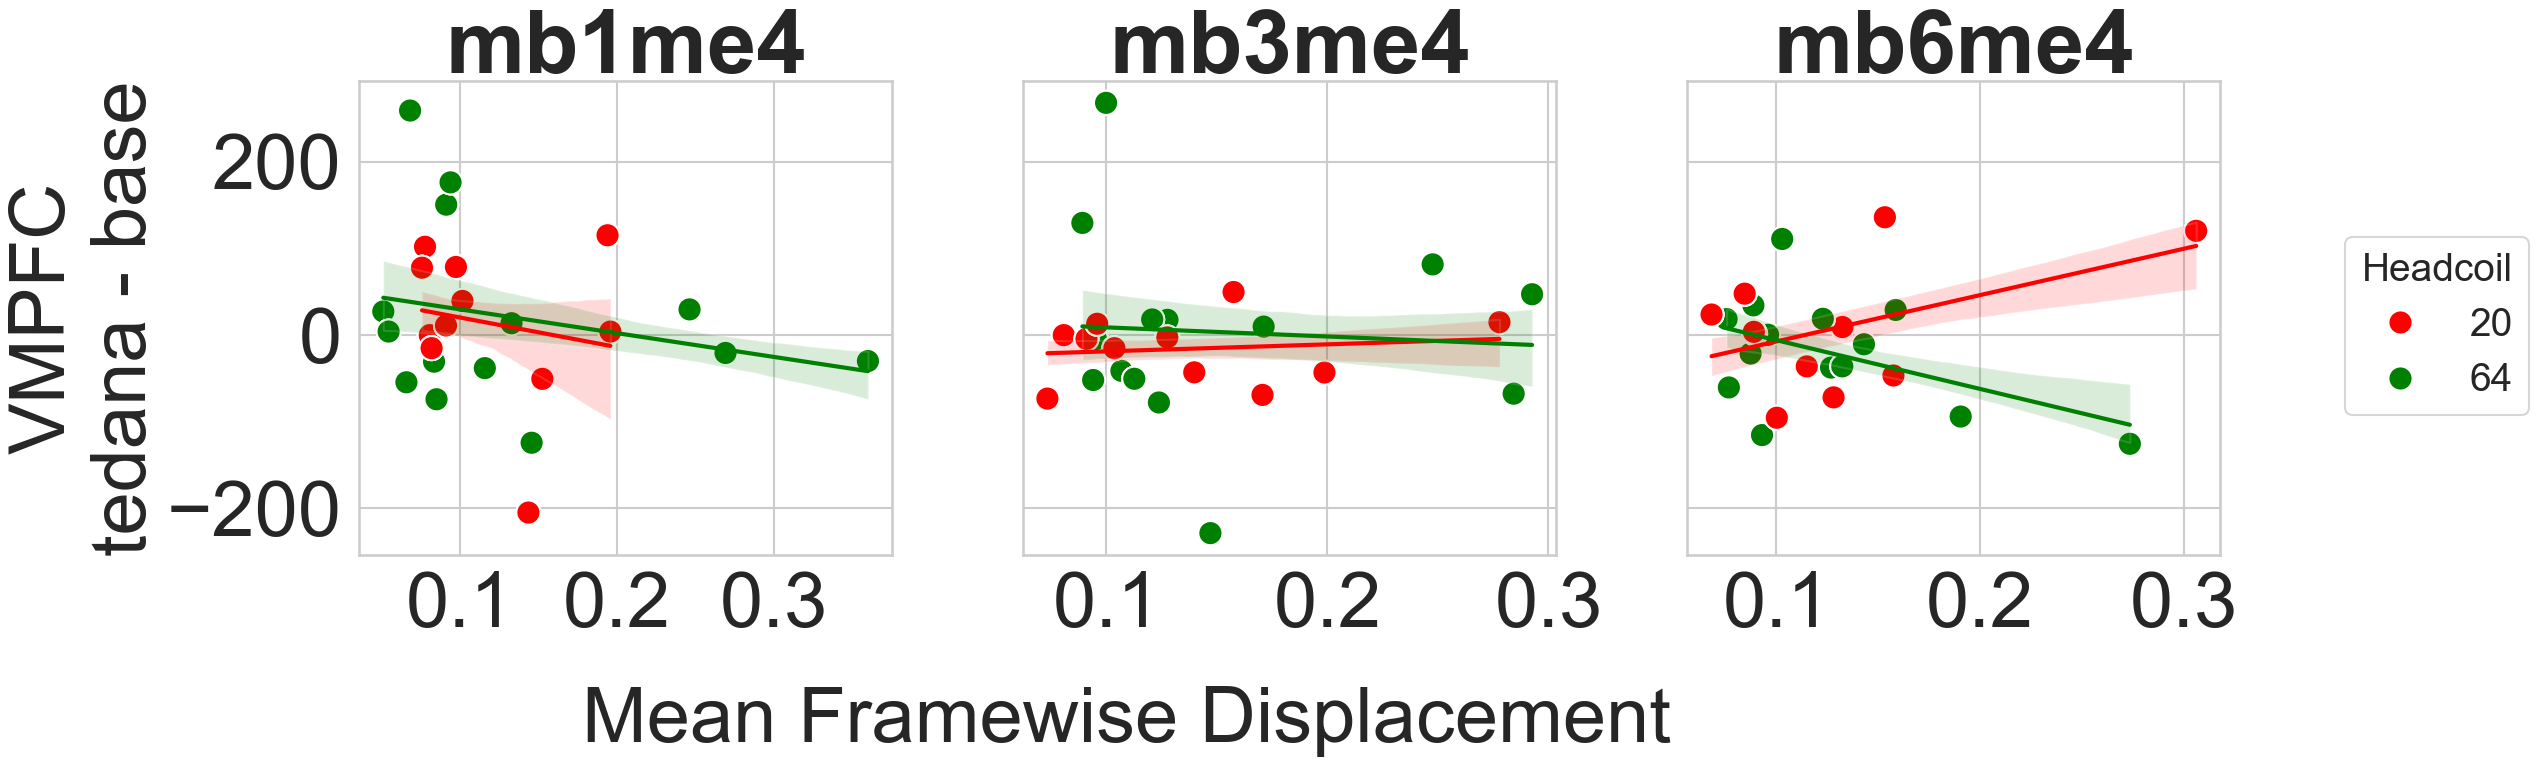

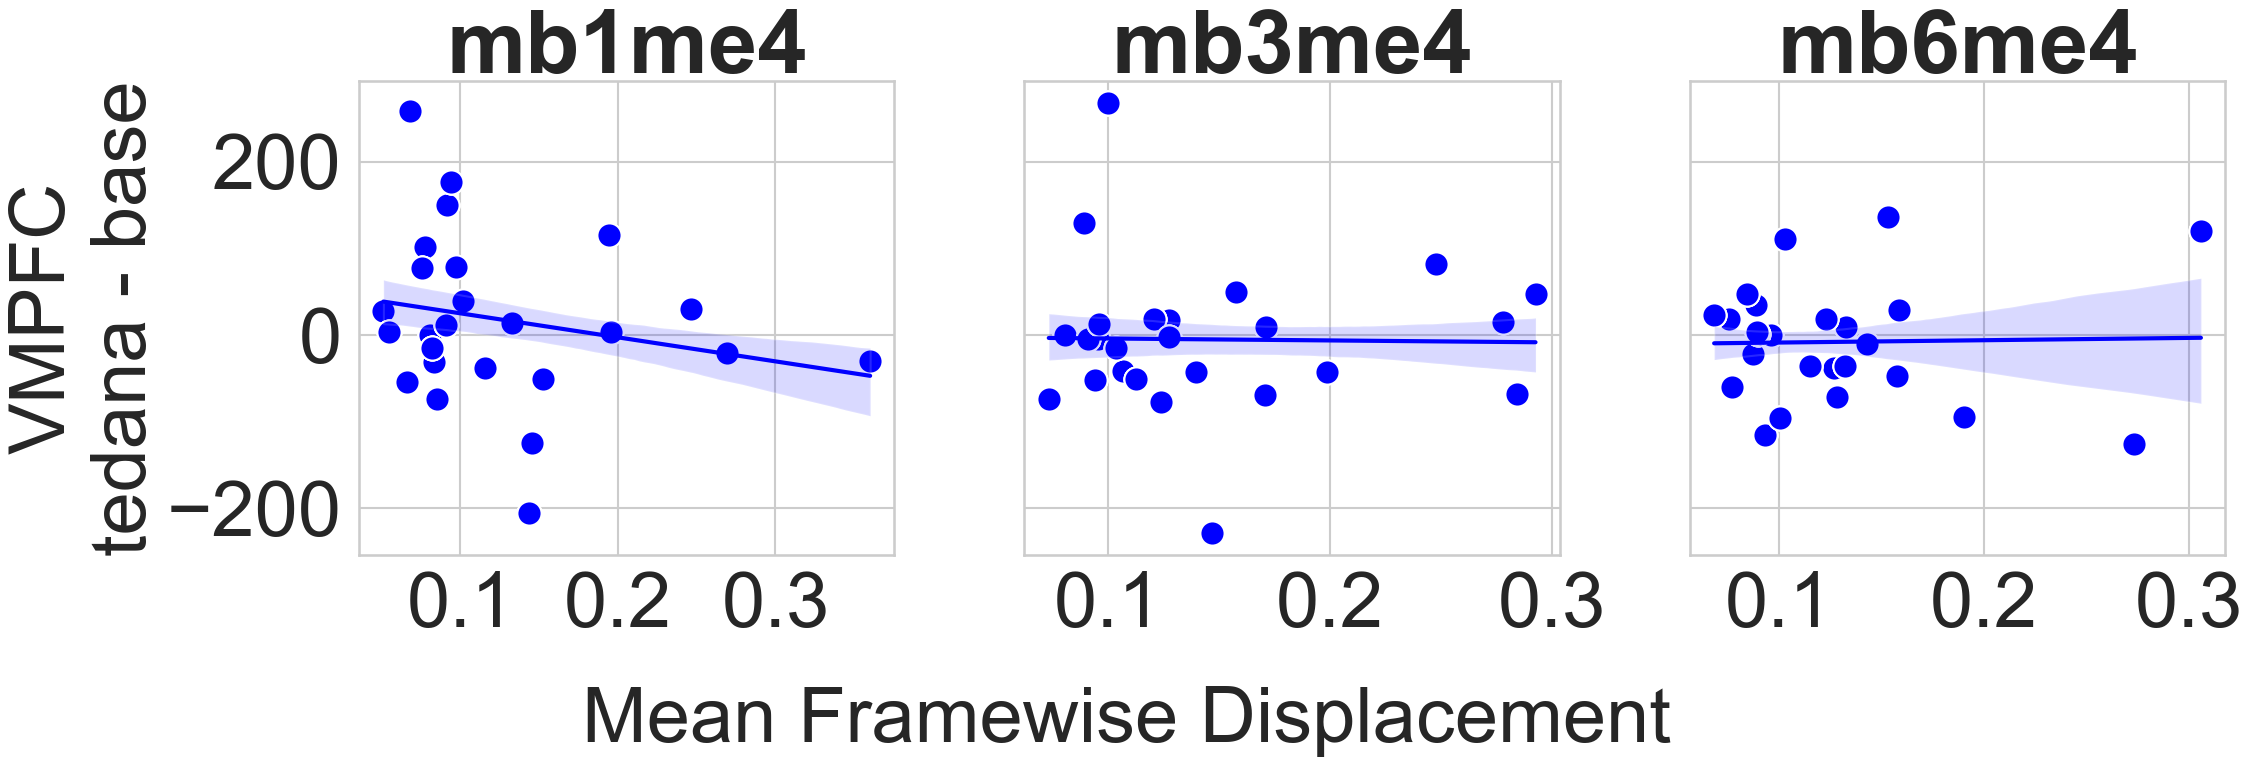

In [19]:
# Figure 8. VMPFC
if __name__ == "__main__":
    # Parameters that can be changed to repurpose the script
    TYPE_VALUE = "act"
    IMG_VALUE = "beta"
    MASK_VALUE = "VMPFC"
    DENOISE_TEDANA = "tedana"
    DENOISE_BASE = "base"
    
    # Run the analysis
    result = process_and_visualize_tedana_difference(
        TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_TEDANA, DENOISE_BASE
    )

In [ ]:
# Figure 8. rFFA
if __name__ == "__main__":
    # Parameters that can be changed to repurpose the script
    TYPE_VALUE = "act"
    IMG_VALUE = "beta"
    MASK_VALUE = "rFFA"
    DENOISE_TEDANA = "tedana"
    DENOISE_BASE = "base"
    
    # Run the analysis
    result = process_and_visualize_tedana_difference(
        TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_TEDANA, DENOISE_BASE
    )

In [ ]:
# Figure 8. bilateralMotor
if __name__ == "__main__":
    # Parameters that can be changed to repurpose the script
    TYPE_VALUE = "act"
    IMG_VALUE = "beta"
    MASK_VALUE = "bilateralMotor"
    DENOISE_TEDANA = "tedana"
    DENOISE_BASE = "base"
    
    # Run the analysis
    result = process_and_visualize_tedana_difference(
        TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_TEDANA, DENOISE_BASE
    )

In [ ]:
# Figure 8. bilateralCerebellum
if __name__ == "__main__":
    # Parameters that can be changed to repurpose the script
    TYPE_VALUE = "act"
    IMG_VALUE = "beta"
    MASK_VALUE = "bilateralCerebellum"
    DENOISE_TEDANA = "tedana"
    DENOISE_BASE = "base"
    
    # Run the analysis
    result = process_and_visualize_tedana_difference(
        TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_TEDANA, DENOISE_BASE
    )

In [ ]:
# Define functions for Figure 9

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

def extract_file_data(base_dir, acq_params, type_value, img_value, mask_value, denoise_value):
    """
    Extracts numerical data from text files matching specified parameters.
    
    Parameters:
    - base_dir: Path to the directory containing text files.
    - acq_params: List of acquisition parameters to include.
    - type_value, img_value, mask_value, denoise_value: Filtering criteria for filenames.
    
    Returns:
    - data_by_subject: Dictionary with subjects as keys and acquisition data as values.
    """
    pattern = re.compile(
        r"ts_sub-(\d+[a-zA-Z]*)_acq_([^_]+)_type-(.+?)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )

    data_by_subject = {}
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    matched_files = 0
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' not in sub_id:
                continue
            if (file_type.lower() == type_value.lower() and 
                img.lower() == img_value.lower() and 
                mask.lower() == mask_value.lower() and 
                denoise.lower() == denoise_value.lower() and 
                acq in acq_params):
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in acq_params}
                    data_by_subject[sub_id][acq] = value
                    matched_files += 1
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")

    print(f"Total matched files: {matched_files}")
    return data_by_subject

def create_dataframe(data_by_subject, acq_params):
    """
    Converts extracted data into a structured DataFrame.

    Parameters:
    - data_by_subject: Dictionary with extracted numerical values.
    - acq_params: List of acquisition parameters (column order).
    
    Returns:
    - df: DataFrame with subject IDs and extracted values.
    """
    df = pd.DataFrame.from_dict(data_by_subject, orient='index').reset_index()
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    column_order = ['subject'] + acq_params
    df = df[column_order].sort_values('subject')
    
    return df

def prepare_plot_data(df, acq_params):
    """
    Computes means and standard errors for each acquisition parameter.

    Parameters:
    - df: DataFrame containing extracted values.
    - acq_params: List of acquisition parameters.

    Returns:
    - results: Dictionary with mean values, errors, and subject count.
    """
    means = {acq: df[acq].mean() for acq in acq_params}
    errors = {acq: df[acq].sem() for acq in acq_params}
    return {'means': means, 'errors': errors, 'count': len(df)}

def create_bar_plot(plot_data, acq_params, title, y_label):
    """
    Creates a formatted bar plot with error bars.

    Parameters:
    - plot_data: Dictionary with mean values, errors, and subject count.
    - acq_params: List of acquisition parameters.
    - title: Plot title.
    - y_label: Y-axis label.

    Returns:
    - fig: The created matplotlib figure.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.set_style("whitegrid")
    sns.set_context("talk")

    means = [plot_data['means'][acq] for acq in acq_params]
    errors = [plot_data['errors'][acq] for acq in acq_params]
    
    x_positions = np.arange(len(acq_params))
    ax.bar(x_positions, means, color='lavender', yerr=errors, capsize=5, width=0.8)

    ax.set_ylabel(y_label, fontsize=40)
    ax.set_title(title, fontsize=48, fontweight='bold')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(acq_params, fontsize=32, rotation=45, ha='right')
    ax.set_xlabel('Acquisition', fontsize=40)
    ax.tick_params(axis='both', labelsize=32)

    # Adjust y-axis limits dynamically
    y_min = min([v - e for v, e in zip(means, errors) if not np.isnan(v)])
    y_max = max([v + e for v, e in zip(means, errors) if not np.isnan(v)])
    margin = (y_max - y_min) * 0.1
    ax.set_ylim(y_min - margin, y_max + margin)

    plt.tight_layout()
    return fig

def process_and_visualize(base_dir, acq_params, type_value, img_value, mask_value, denoise_value):
    """
    Full pipeline to extract, process, and visualize data.

    Parameters:
    - base_dir: Path to data files.
    - acq_params: List of acquisition parameters.
    - type_value, img_value, mask_value, denoise_value: Filtering criteria.

    Returns:
    - df: Processed DataFrame.
    - fig: Generated bar plot figure.
    """
    print(f"Processing files with parameters: type={type_value}, img={img_value}, mask={mask_value}, denoise={denoise_value}")
    
    data_by_subject = extract_file_data(base_dir, acq_params, type_value, img_value, mask_value, denoise_value)
    
    if not data_by_subject:
        print("No matching files found.")
        return pd.DataFrame(columns=['subject'] + acq_params), plt.figure()
    
    df = create_dataframe(data_by_subject, acq_params)
    df.to_csv(f"multiecho_data_{type_value}_{img_value}_{mask_value}_{denoise_value}.csv", index=False)

    plot_data = prepare_plot_data(df, acq_params)
    fig = create_bar_plot(plot_data, acq_params, f"sp Subjects (n={plot_data['count']})", 'VS zstat, Reward > Punishment')

    plot_file = f"multiecho_plots_{type_value}_{img_value}_{mask_value}_{denoise_value}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    return df, fig


In [ ]:
# Figure 9. Beta estimates for activation for each acquisition in VS for ‘SP’ subjects
if __name__ == "__main__":
    BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
    ACQ_PARAMS = ["mb3me1fa50", "mb3me3", "mb3me3ip0", "mb2me4", "mb3me4", "mb3me4fa50"]
    
    df, fig = process_and_visualize(
        base_dir=BASE_DIR, 
        acq_params=ACQ_PARAMS, 
        type_value="act", 
        img_value="beta", 
        mask_value="VSconstrained", 
        denoise_value="base"
    )


In [ ]:
# Supp. Figure 9. zstat for activation for each acquisition in VS for ‘SP’ subjects
if __name__ == "__main__":
    BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
    ACQ_PARAMS = ["mb3me1fa50", "mb3me3", "mb3me3ip0", "mb2me4", "mb3me4", "mb3me4fa50"]
    
    df, fig = process_and_visualize(
        base_dir=BASE_DIR, 
        acq_params=ACQ_PARAMS, 
        type_value="act", 
        img_value="zstat", 
        mask_value="VSconstrained", 
        denoise_value="base"
    )